In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm
from scipy.optimize import minimize
from scipy.optimize import curve_fit
import os
from matplotlib.lines import Line2D
from tqdm import tqdm
from collections import defaultdict

%matplotlib inline

In [ ]:
signal_dir = "/scratch/elena/WCTE_DATA_ANALYSIS/waveform_npz/run2521/"
control_dir = "/scratch/elena/WCTE_DATA_ANALYSIS/waveform_npz/run2519/"

signal_files = [f for f in os.listdir(signal_dir) if f.endswith(".npz")]
control_files = [f for f in os.listdir(control_dir) if f.endswith(".npz")]

signal_pmts = set(f.replace(".npz", "") for f in signal_files)
control_pmts = set(f.replace(".npz", "") for f in control_files)

pmts_both = sorted(list(signal_pmts & control_pmts))

print(f"Number of PMTs in both files: {len(pmts_both)}")
print("Some examples:", pmts_both[:20])

Number of PMTs in both files: 1548
Some examples: ['card100_slot24_ch0', 'card100_slot24_ch1', 'card100_slot24_ch10', 'card100_slot24_ch11', 'card100_slot24_ch12', 'card100_slot24_ch13', 'card100_slot24_ch14', 'card100_slot24_ch15', 'card100_slot24_ch16', 'card100_slot24_ch17', 'card100_slot24_ch18', 'card100_slot24_ch2', 'card100_slot24_ch3', 'card100_slot24_ch4', 'card100_slot24_ch5', 'card100_slot24_ch6', 'card100_slot24_ch7', 'card100_slot24_ch8', 'card100_slot24_ch9', 'card101_slot20_ch0']


In [ ]:
card_id = 100
slot_id = 24
channel_id = 11

pmt_label = f"card{card_id}_slot{slot_id}_ch{channel_id}"

signal_npz = f"/scratch/elena/WCTE_DATA_ANALYSIS/waveform_npz/run2521/{pmt_label}.npz"    #signal run2521 with diffuser laser ball
control_npz = f"/scratch/elena/WCTE_DATA_ANALYSIS/waveform_npz/run2519/{pmt_label}.npz"   #control run2519

In [4]:
def load_waveforms(npz_file):
    data = np.load(npz_file)
    return data["waveforms"]  # shape: (n_events, n_bins)

signal_waveforms = load_waveforms(signal_npz)
control_waveforms = load_waveforms(control_npz)

print("Loaded signal waveforms:", signal_waveforms.shape)
print("Loaded control waveforms:", control_waveforms.shape)

Loaded signal waveforms: (10000, 64)
Loaded control waveforms: (10000, 64)


In [5]:
def compute_charges(waveforms, integration_range=None):
    """
    Calcula la carga integrada de cada waveform.
    waveforms: (n_events, n_bins)
    integration_range: tuple (lo, hi) en bins. Si None, usa toda la waveform.
    """
    if integration_range is None:
        return waveforms.sum(axis=1)
    lo, hi = integration_range
    return waveforms[:, lo:hi].sum(axis=1)

#icompute charges
signal_charges = compute_charges(signal_waveforms)
control_charges = compute_charges(control_waveforms)

print("Signal charges:", signal_charges.shape)
print("Control charges:", control_charges.shape)

Signal charges: (10000,)
Control charges: (10000,)


Eso que comentas indica que ahora lo que has calculado (signal_charges, control_charges) ya no son waveforms, sino los valores integrados de carga por cada waveform.

Te explico:

Antes (signal_waveforms.shape = (10000, 64)):
→ 10 000 waveforms (triggers) × 64 samples cada una.

Después de aplicar compute_charges(...):
→ signal_charges.shape = (10000,) porque hemos colapsado los 64 samples en un único número (la carga integrada de cada waveform).

Esto es totalmente esperado.
Ya no tenemos la forma temporal de cada pulso, sino un histograma de cargas integradas → eso es justo lo que quieres para ver el pedestal vs s.p.e.

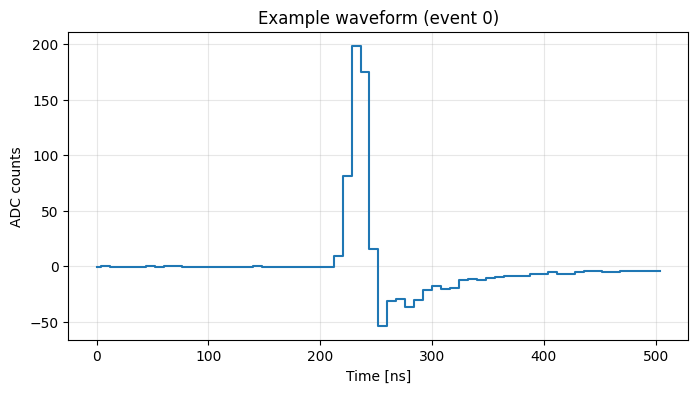

Integrated charge for event 0: 55.40 ADC·counts


In [6]:
#seleccionar un random event
i = 0  
wf = signal_waveforms[i]


plt.figure(figsize=(8,4))
plt.plot(np.arange(64)*8, wf, drawstyle="steps-mid")
plt.xlabel("Time [ns]")
plt.ylabel("ADC counts")
plt.title(f"Example waveform (event {i})")
plt.grid(alpha=0.3)
plt.show()

# Calcular la carga de esta waveform
charge = np.sum(wf)
print(f"Integrated charge for event {i}: {charge:.2f} ADC·counts")

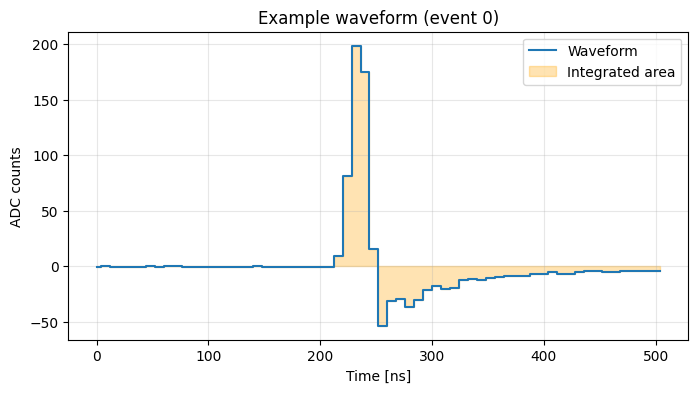

Integrated charge for event 0: 443.20 ADC·ns


In [7]:
# Selecciona un evento cualquiera
i = 0  
wf = signal_waveforms[i]

# Eje de tiempos (64 samples * 8 ns)
time_axis = np.arange(64) * 8  

# Calcular la carga: sumatoria de wf * 8 ns
charge = np.sum(wf) * 8  

plt.figure(figsize=(8,4))
plt.plot(time_axis, wf, drawstyle="steps-mid", label="Waveform")
plt.fill_between(time_axis, wf, step="mid", alpha=0.3, color="orange", label="Integrated area")
plt.xlabel("Time [ns]")
plt.ylabel("ADC counts")
plt.title(f"Example waveform (event {i})")
plt.legend()
plt.grid(alpha=0.3)
plt.show()

print(f"Integrated charge for event {i}: {charge:.2f} ADC·ns")   # x8 ns porque cada sample (64 per waveform) es de 8ns

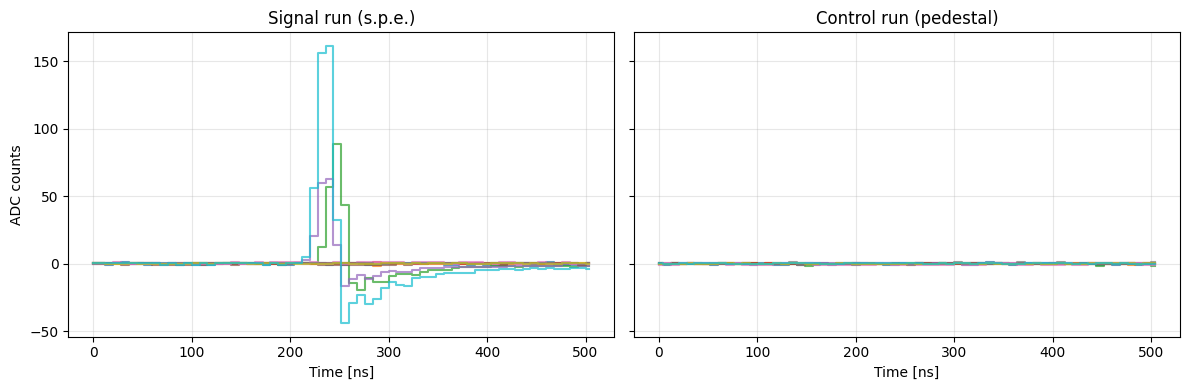

In [8]:
def plot_random_waveforms(signal_waveforms, control_waveforms, n_events=5):

    #random indices de waveforms (random events)
    sig_idx = np.random.choice(signal_waveforms.shape[0], n_events, replace=False)
    ctrl_idx = np.random.choice(control_waveforms.shape[0], n_events, replace=False)

    time = np.arange(signal_waveforms.shape[1]) * 8  #cada sample = 8 ns

    fig, axes = plt.subplots(1, 2, figsize=(12, 4), sharey=True)

    #signal
    for i in sig_idx:
        wf = signal_waveforms[i]
        axes[0].plot(time, wf, drawstyle="steps-mid", alpha=0.7)
    axes[0].set_title("Signal run (s.p.e.)")
    axes[0].set_xlabel("Time [ns]")
    axes[0].set_ylabel("ADC counts")
    axes[0].grid(alpha=0.3)

    #control
    for i in ctrl_idx:
        wf = control_waveforms[i]
        axes[1].plot(time, wf, drawstyle="steps-mid", alpha=0.7)
    axes[1].set_title("Control run (pedestal)")
    axes[1].set_xlabel("Time [ns]")
    axes[1].grid(alpha=0.3)

    plt.tight_layout()
    plt.show()


plot_random_waveforms(signal_waveforms, control_waveforms, n_events=10)

En la señal (LED, s.p.e.) → picos muy claros centrados en cierto rango (~200 ns). Eso son tus pulsos de fotoelectrones.

En el control (pedestal) → solo ruido alrededor de cero (sin pulsos). Eso es lo esperado: el trigger se disparó pero sin LED, por lo que solo mides la base electrónica.

In [9]:
card_id = 100
slot_id = 24
channel_id = 8
pmt_label = f"card{card_id}_slot{slot_id}_ch{channel_id}"

signal_npz  = f"/scratch/elena/WCTE_DATA_ANALYSIS/waveform_npz/run2521/{pmt_label}.npz"
control_npz = f"/scratch/elena/WCTE_DATA_ANALYSIS/waveform_npz/run2519/{pmt_label}.npz"

bin_width = 8.0  #ns per bin


def load_waveforms(npz_file):
    data = np.load(npz_file)
    return data["waveforms"]


signal_waveforms = load_waveforms(signal_npz)
control_waveforms = load_waveforms(control_npz)


threshold = 50  #ADC counts

valid_indices = [i for i, wf in enumerate(signal_waveforms) if np.max(wf) > threshold]

if len(valid_indices) == 0:
    raise RuntimeError(f"No waveform above threshold {threshold} found for {pmt_label}")

wf_index = valid_indices[10]
wf = signal_waveforms[wf_index]
peak_idx = int(np.argmax(wf))
n_samples = len(wf)
time_axis = np.arange(n_samples) * bin_width

print(f"Using waveform index {wf_index}, peak at bin {peak_idx}")
print(f"Threshold used: {threshold} ADC counts")


bin_sizes = [4, 5, 6, 7, 8]
all_windows = []

for n_bins in bin_sizes:
    for pre in range(1, n_bins):
        post = n_bins - pre - 1
        if post >= 1 and pre != post:  #discard symmetric and ensure pre<0, post>0
            if pre !=1 and post <=4:
                all_windows.append((-pre, post))

#compute Q and noise for the selected waveform only
results = []
for w in all_windows:
    pre_peak = -w[0]
    post_peak = w[1]

    # define integration limits
    start = max(0, peak_idx - pre_peak)
    end   = min(len(wf), peak_idx + post_peak + 1)
    N = end - start

    
    Q = np.sum(wf[start:end]) * bin_width

    #errors
    sigma_bin = np.std(wf[:10])  # baseline RMS
    sigma_Q = np.sqrt(N) * sigma_bin * bin_width

    #relative error
    rel_err = (sigma_Q / Q) * 100 if Q != 0 else np.nan

    results.append({
        'window': w,
        'n_bins': N,
        'Q': Q,
        'noise': sigma_Q,
        'rel_error(%)': rel_err,
        'start': start,
        'end': end
    })


#table
print("\nResults per window (non-symmetric only):")
print(f"{'window':12s} {'bins':>5s} {'Q [ADC·ns]':>18s} {'σ_Q [ADC·ns]':>12s} {'rel_err [%]':>12s}")


results_sorted_final = sorted(results, key=lambda r: (r['n_bins'], -r['Q']))

best_candidates = results_sorted_final[:3]  # top 3 by this sorting

for r in results_sorted_final:
    print(f"[{r['window'][0]},{r['window'][1]}] {r['n_bins']:5d} "
          f"{r['Q']:18.1f} {r['noise']:12.1f} {r['rel_error(%)']:12.2f}")

print("\nBest candidate integration windows")
for r in best_candidates:
    print(f"Window {r['window']}, bins={r['n_bins']}, "
          f"Q={r['Q']:.1f}, σ_Q={r['noise']:.1f}, rel_err={r['rel_error(%)']:.2f}%")


Using waveform index 49, peak at bin 30
Threshold used: 50 ADC counts

Results per window (non-symmetric only):
window        bins         Q [ADC·ns] σ_Q [ADC·ns]  rel_err [%]
[-2,1]     4             1028.8          4.8         0.47
[-3,1]     5             1036.0          5.4         0.52
[-4,1]     6             1035.2          5.9         0.57
[-3,2]     6              931.2          5.9         0.63
[-2,3]     6              835.2          5.9         0.70
[-5,1]     7             1034.4          6.3         0.61
[-4,2]     7              930.4          6.3         0.68
[-2,4]     7              786.4          6.3         0.81
[-6,1]     8             1041.6          6.8         0.65
[-5,2]     8              929.6          6.8         0.73
[-4,3]     8              841.6          6.8         0.81
[-3,4]     8              793.6          6.8         0.86

Best candidate integration windows
Window (-2, 1), bins=4, Q=1028.8, σ_Q=4.8, rel_err=0.47%
Window (-3, 1), bins=5, Q=1036.0, σ

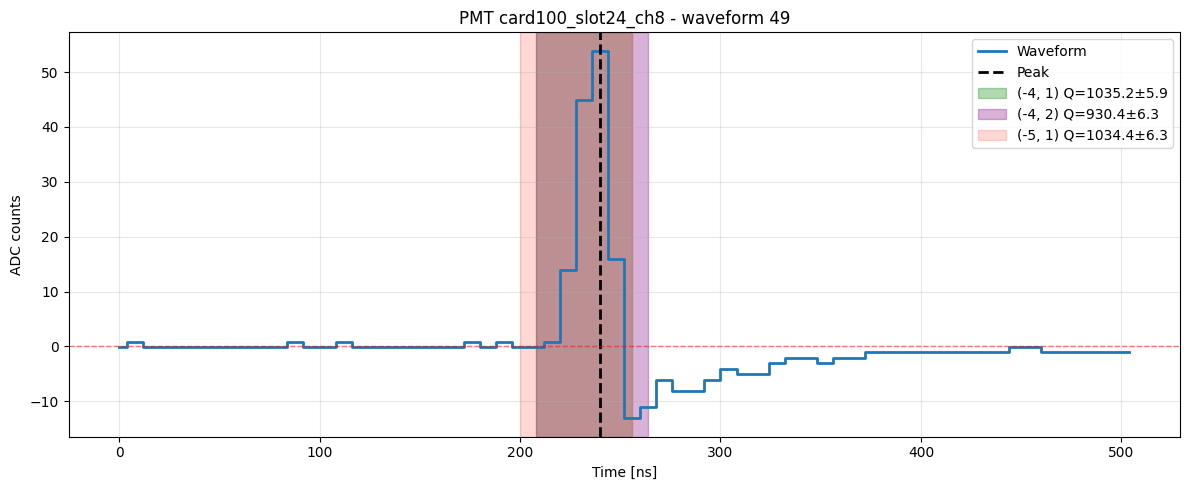

In [10]:
candidate_windows = [(-4,2), (-5,1), (-4,1)]

results_candidates = [r for r in results if r['window'] in candidate_windows]

plt.figure(figsize=(12,5))
plt.plot(time_axis, wf, drawstyle="steps-mid", lw=2, label=f"Waveform")
plt.axvline(peak_idx*bin_width, color='k', ls='--', lw=2, label='Peak')


color_map_fixed = {
    (-4,2): 'purple',
    (-5,1): 'salmon',   
    (-4,1): 'green'
}

for r in results_candidates:
    xs = time_axis[r['start']]
    xe = time_axis[r['end']-1] + bin_width
    plt.axvspan(xs, xe, alpha=0.3, color=color_map_fixed[r['window']], 
                label=f"{r['window']} Q={r['Q']:.1f}±{r['noise']:.1f}")
    plt.axhline(0, color="red", linestyle = "--", lw=1, alpha=0.2)

plt.xlabel("Time [ns]")
plt.ylabel("ADC counts")
plt.title(f"PMT {pmt_label} - waveform {wf_index}")
plt.legend(fontsize=10, ncol=1, frameon=True)
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

Number of windows after filtering: 9


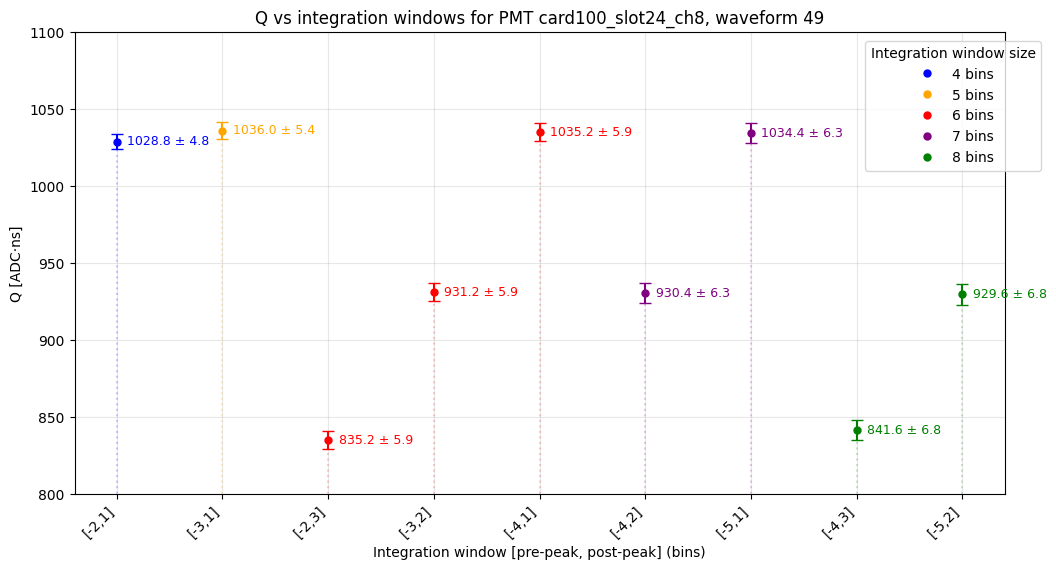

In [11]:
candidate_windows = [(-4,2), (-5,1), (-4,1)]
extra_bins = [4, 5, 6, 7, 8] 


plot_results = []
for r in results:
    pre, post = r['window']
    if pre in (-1,-6):
        continue  # discard pre=-1
    if post in (4, 5):
        continue  # discard post=+4 or +5
    if r['window'] in candidate_windows or r['n_bins'] in extra_bins:
        plot_results.append(r)


print("Number of windows after filtering:", len(plot_results))


color_map_bins = {
    4: 'blue',
    5: 'orange',
    6: 'red',
    7: 'purple',
    8: 'green'
}


#scatter plot
plt.figure(figsize=(12,6))

#convert integration windows to strings for x-axis
x_labels = [f"[{w[0]},{w[1]}]" for w in [r['window'] for r in plot_results]]

#numeric positions for plotting
x_pos = range(len(plot_results))

for i, r in enumerate(plot_results):
    w = r['window']
    Q = r['Q']
    sigma_Q = r['noise']
    n_bins = r['n_bins']
    color = color_map_bins[n_bins]


    plt.errorbar(
        x_pos[i], Q, yerr=sigma_Q,
        fmt='o', color=color,
        markersize=5, capsize=4
    )

    #vertical lines
    plt.vlines(
        x=x_pos[i], ymin=0, ymax=Q,
        colors=color, linestyles="dotted", alpha=0.2
    )

    #text Q+-sigma_Q
    plt.text(
        x_pos[i] + 0.1, Q,
        f"{Q:.1f} ± {sigma_Q:.1f}",
        color=color,
        fontsize=9,
        va='center'
    )

#set labels
plt.xticks(x_pos, x_labels, rotation=45, ha='right')

#legend
custom_lines = [Line2D([0], [0], color=color_map_bins[b], marker='o', lw=0, markersize=5, label=f"{b} bins")
                for b in sorted(color_map_bins.keys())]

plt.legend(handles=custom_lines, title="Integration window size", fontsize=10, loc=(0.85,0.7))
plt.xlabel("Integration window [pre-peak, post-peak] (bins)")
plt.ylabel("Q [ADC·ns]")
plt.title(f"Q vs integration windows for PMT {pmt_label}, waveform {wf_index}")
plt.grid(alpha=0.3)
#plt.tight_layout()
plt.ylim(800,1100)
plt.show()

In [12]:
integration_windows = [(-4, 2), (-5, 1), (-4, 1), (-2,1), (-3,1)]

#store results per PMT
results_all_pmts = {w: [] for w in integration_windows}

bin_width = 8.0 
threshold = 50   

def load_waveforms(npz_file):
    data = np.load(npz_file)
    return data["waveforms"]

def window_noise(wf, start, end):
    """Compute RMS of waveform in given window (represents noise contribution)"""
    return np.sqrt(np.mean(wf[start:end]**2))

#loop over PMTs present in signal_pmts only (with progress bar)
total_pmts = len(signal_pmts)
print(f"Processing {total_pmts} PMTs from signal...")

for pmt_id in tqdm(signal_pmts, desc="Processing PMTs"):
    parts = pmt_id.replace("card", "").replace("slot", "").replace("ch", "").split("_")  #parse card, slot, channel
    card_id, slot_id, channel_id = map(int, parts)
    pmt_label = f"card{card_id}_slot{slot_id}_ch{channel_id}"

    #load waveforms
    try:
        signal_waveforms = load_waveforms(f"/scratch/elena/waveform_npz/run2521/{pmt_label}.npz")
    except FileNotFoundError:
        #print(f"Warning: waveform file not found for {pmt_label}, skipping.")
        continue

    #select valid waveforms above threshold
    valid_indices = [i for i, wf in enumerate(signal_waveforms) if np.max(wf) > threshold]
    if not valid_indices:
        continue  #skip PMT if not matching the conditions

    #loop over candidate windows
    for window in integration_windows:
        pre_peak = -window[0]
        post_peak = window[1]

        Qs = []
        sigmas = []
        for wf_idx in valid_indices:
            wf_evt = signal_waveforms[wf_idx]
            peak_idx_evt = np.argmax(wf_evt)
            start = max(0, peak_idx_evt - pre_peak)
            end   = min(len(wf_evt), peak_idx_evt + post_peak + 1)
            N = end - start

            #integrated charge
            Q = np.sum(wf_evt[start:end]) * bin_width

            #noise contribution
            sigma_bin = np.std(wf_evt[:10])  # baseline RMS
            sigma_Q = np.sqrt(N) * sigma_bin * bin_width

            Qs.append(Q)
            sigmas.append(sigma_Q)

        Qs = np.array(Qs)
        sigmas = np.array(sigmas)

        # store per PMT: average Q, average sigma_Q, S/N (Q/sigma)
        avg_Q = np.mean(Qs)
        avg_sigma = np.mean(sigmas)
        sn_ratio = avg_Q / avg_sigma if avg_sigma != 0 else np.nan

        results_all_pmts[window].append({
            'pmt': pmt_label,
            'avg_Q': avg_Q,
            'avg_sigma': avg_sigma,
            'S_over_N': sn_ratio
        })

#compute overall Q, sigma_Q and S/N across all PMTs
summary_results = []
for window, res_list in results_all_pmts.items():
    avg_Q_all = np.mean([r['avg_Q'] for r in res_list])
    avg_sigma_all = np.mean([r['avg_sigma'] for r in res_list])
    avg_sn_all = np.mean([r['S_over_N'] for r in res_list])
    summary_results.append({
        'window': window,
        'avg_Q': avg_Q_all,
        'avg_sigma': avg_sigma_all,
        'avg_SNR': avg_sn_all
    })

#sort by Q descending, then sigma ascending (prioritize signal vs noise) ---
summary_sorted = sorted(summary_results, key=lambda r: (-r['avg_Q'], r['avg_sigma']))

#results
print("\nSummary of candidate integration windows across all PMTs:")
print(f"{'window':12s} {'avg_Q [ADC·ns]':>15s} {'avg_sigma_Q':>15s} {'avg S/N':>10s}")
for r in summary_sorted:
    w = r['window']
    print(f"[{w[0]},{w[1]}] {r['avg_Q']:15.1f} {r['avg_sigma']:15.1f} {r['avg_SNR']:10.2f}")

#best 2 integration windows 
best_two = summary_sorted[:2]
print("\nTwo best integration windows (max Q, min sigma_Q):")
for r in best_two:
    w = r['window']
    print(f"Window {w}: avg_Q = {r['avg_Q']:.1f}, avg_sigma_Q = {r['avg_sigma']:.1f}, avg_S/N = {r['avg_SNR']:.2f}")


Processing 1548 PMTs from signal...


Processing PMTs:   0%|                                                                                                                         | 0/1548 [00:00<?, ?it/s]

Processing PMTs: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████| 1548/1548 [00:00<00:00, 15076.63it/s]


Summary of candidate integration windows across all PMTs:
window        avg_Q [ADC·ns]     avg_sigma_Q    avg S/N
[-4,2]             nan             nan        nan
[-5,1]             nan             nan        nan
[-4,1]             nan             nan        nan
[-2,1]             nan             nan        nan
[-3,1]             nan             nan        nan

Two best integration windows (max Q, min sigma_Q):
Window (-4, 2): avg_Q = nan, avg_sigma_Q = nan, avg_S/N = nan
Window (-5, 1): avg_Q = nan, avg_sigma_Q = nan, avg_S/N = nan



/dipc/elena/.local/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3441: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/dipc/elena/.local/lib/python3.7/site-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


S/N = Signal/Noise i.e. Q/sigma_Q. 

avg_S/N se calcula promediando esos valores sobre todas las waveforms y PMTs. Cuanto mayor sea avg_S/N, más limpia es la señas edntro de esa ventana (mucha señal, poco ruido)

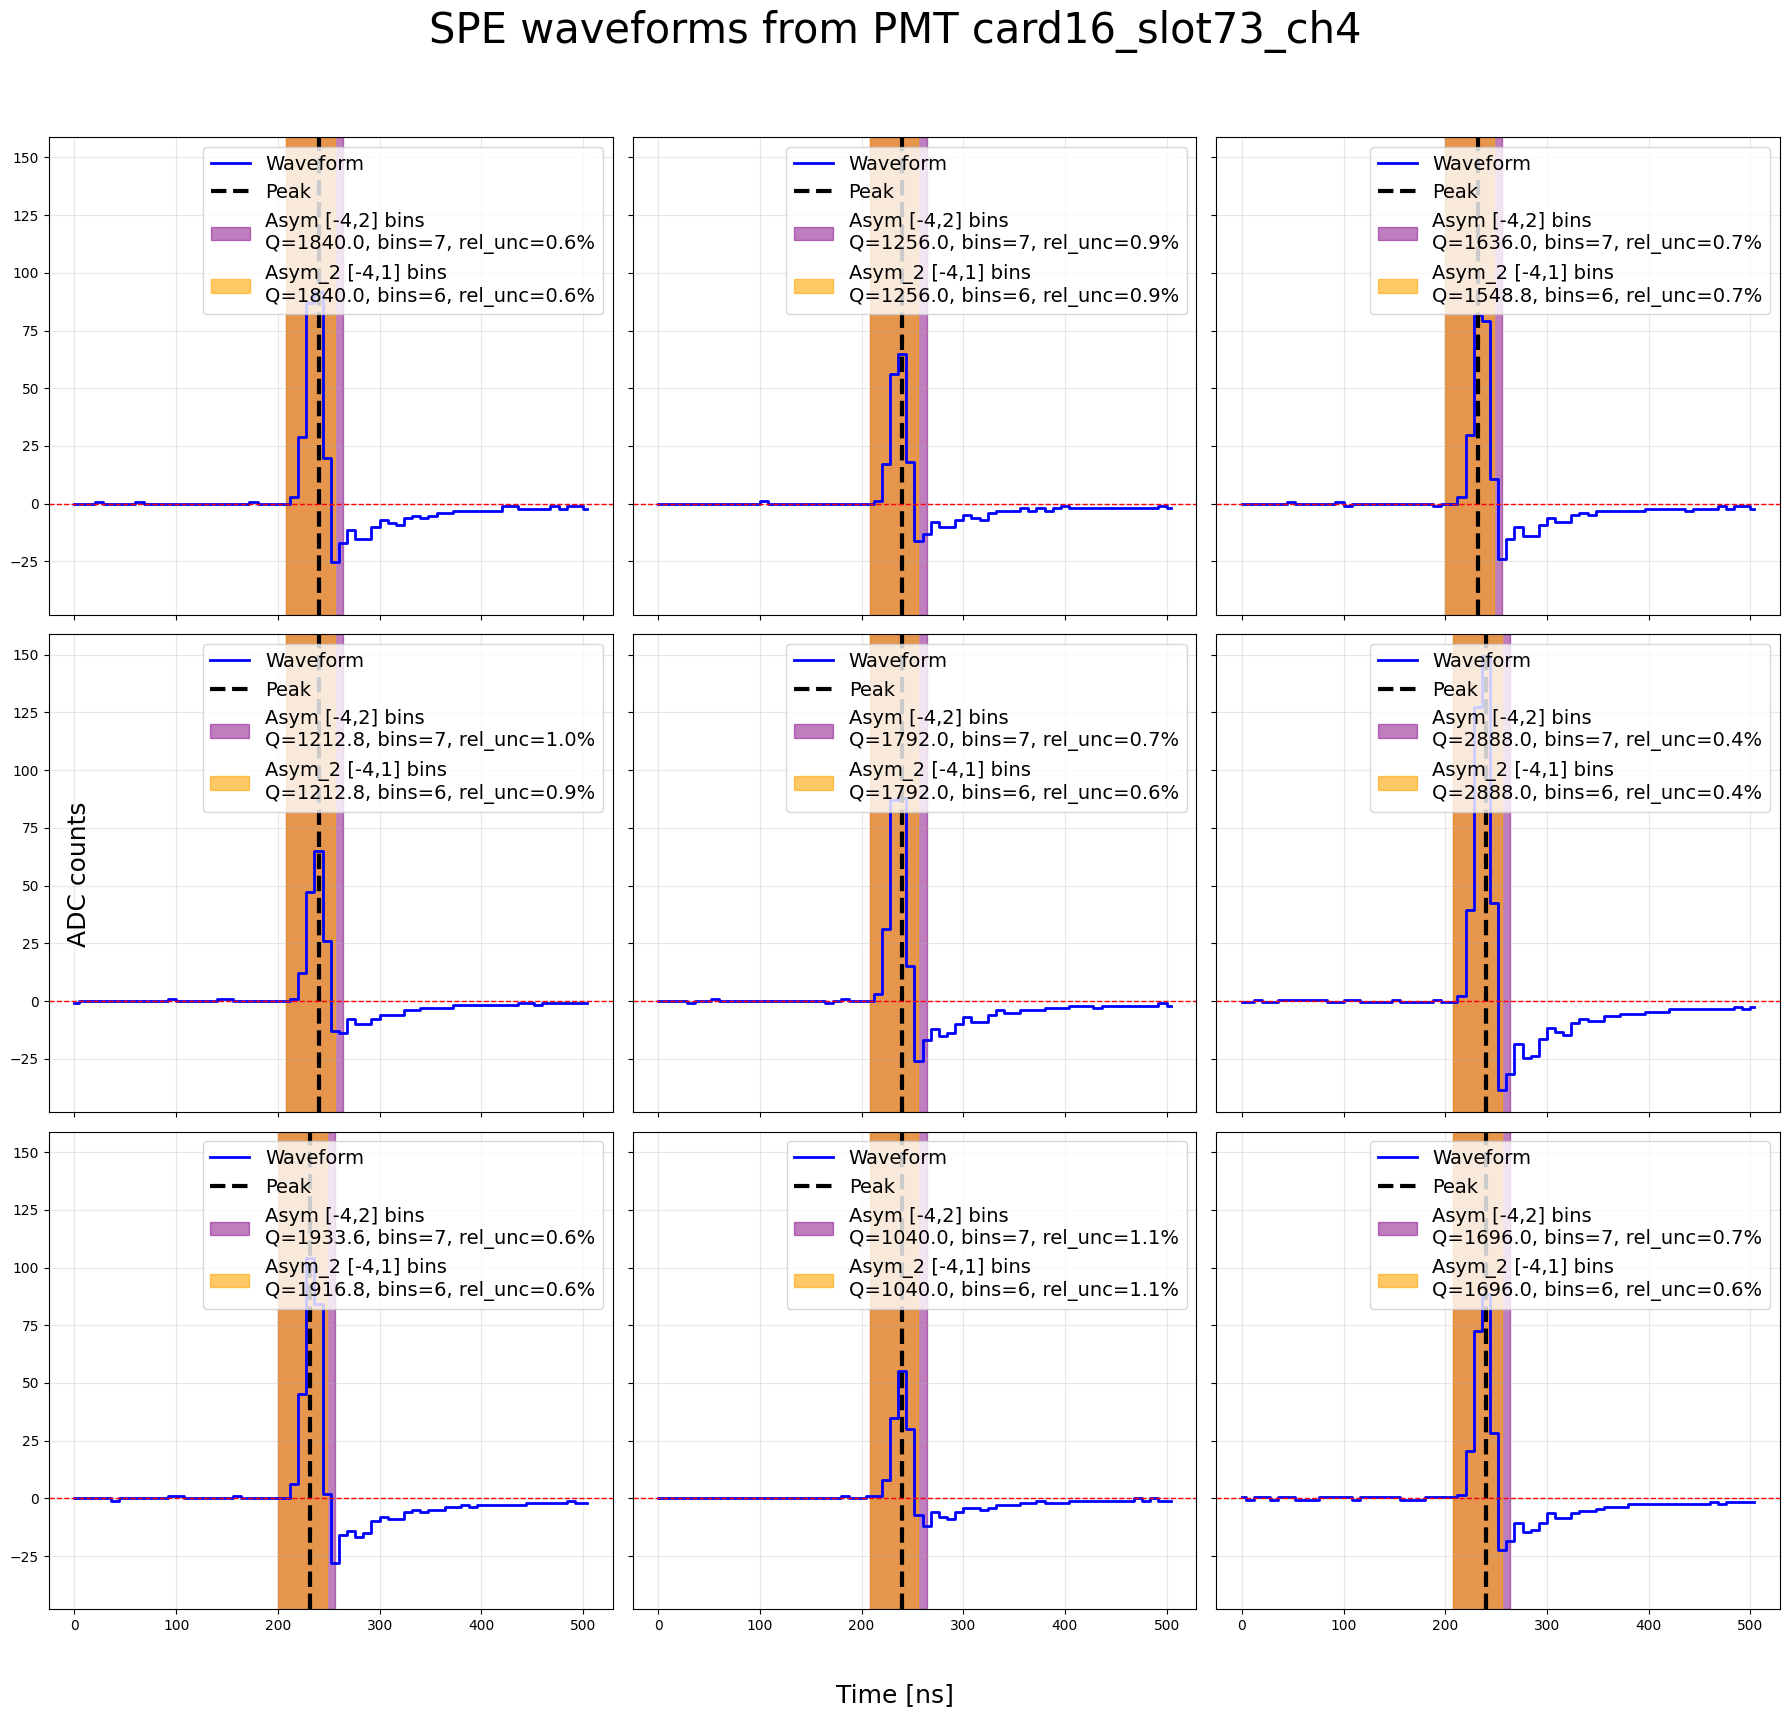

In [13]:
time_axis = np.arange(signal_waveforms.shape[1]) * bin_width

asym_window = (-4, +2)   
asym_window_2 = (-4, +1)    

#noise estimation (from pedestal run or RMS of baseline in signal run)
sigma_sample = np.std(control_waveforms[:, :20])  # adjust baseline region if needed

n_rows, n_cols = 3,3
n_waveforms = n_rows * n_cols
threshold = 50  # ADC counts

valid_indices = [i for i, wf in enumerate(signal_waveforms) if np.max(wf) > threshold]

#chose random waveforms!
indices = np.random.choice(valid_indices, n_waveforms, replace=False)

fig, axes = plt.subplots(n_rows, n_cols, figsize=(18, 18), sharex=True, sharey=True)

for ax, idx in zip(axes.flat, indices):
    wf = signal_waveforms[idx]
    peak_idx = int(np.argmax(wf))
    
    #Asymmetric window
    start_asym = max(0, peak_idx + asym_window[0])
    end_asym   = min(len(wf), peak_idx + asym_window[1] + 1)
    bins_asym = end_asym - start_asym
    Q_asym = np.sum(np.clip(wf[start_asym:end_asym], 0, None)) * bin_width
    sigma_Q_asym = np.sqrt(bins_asym) * sigma_sample * bin_width
    rel_unc_asym = sigma_Q_asym / Q_asym * 100 if Q_asym > 0 else np.nan
    
    #Asymmetric window 2
    start_asym_2 = max(0, peak_idx + asym_window_2[0])
    end_asym_2   = min(len(wf), peak_idx + asym_window_2[1] + 1)
    bins_asym_2 = end_asym_2 - start_asym_2
    Q_asym_2 = np.sum(np.clip(wf[start_asym_2:end_asym_2], 0, None)) * bin_width
    sigma_Q_asym_2 = np.sqrt(bins_asym_2) * sigma_sample * bin_width
    rel_unc_asym_2 = sigma_Q_asym_2 / Q_asym_2 * 100 if Q_asym_2 > 0 else np.nan
    
    ax.plot(time_axis, wf, drawstyle="steps-mid", lw=2, color="blue", label="Waveform")
    ax.axvline(peak_idx * bin_width, color="k", linestyle="--", lw=3, label="Peak")
   
    ax.axvspan(time_axis[start_asym], time_axis[end_asym-1] + bin_width,
               alpha=0.5, color="purple", label=(
                   f"Asym [{asym_window[0]},{asym_window[1]}] bins\n"
                   f"Q={Q_asym:.1f}, bins={bins_asym}, rel_unc={rel_unc_asym:.1f}%"))
    ax.axhline(0, color="red", linestyle = "--", lw=1)
    
    ax.axvspan(time_axis[start_asym_2], time_axis[end_asym_2-1] + bin_width,
               alpha=0.6, color="orange", label=(
                   f"Asym_2 [{asym_window_2[0]},{asym_window_2[1]}] bins\n"
                   f"Q={Q_asym_2:.1f}, bins={bins_asym_2}, rel_unc={rel_unc_asym_2:.1f}%"))
    
    ax.legend(fontsize=14, loc="upper right")
    ax.grid(alpha=0.3)

fig.text(0.5, 0.04, "Time [ns]", ha="center", fontsize=18)
fig.text(0.04, 0.5, "ADC counts", va="center", rotation="vertical", fontsize=18)
fig.suptitle(f"SPE waveforms from PMT {pmt_label}", fontsize=30)
plt.tight_layout(rect=[0, 0.07, 1, 0.95])
plt.show()

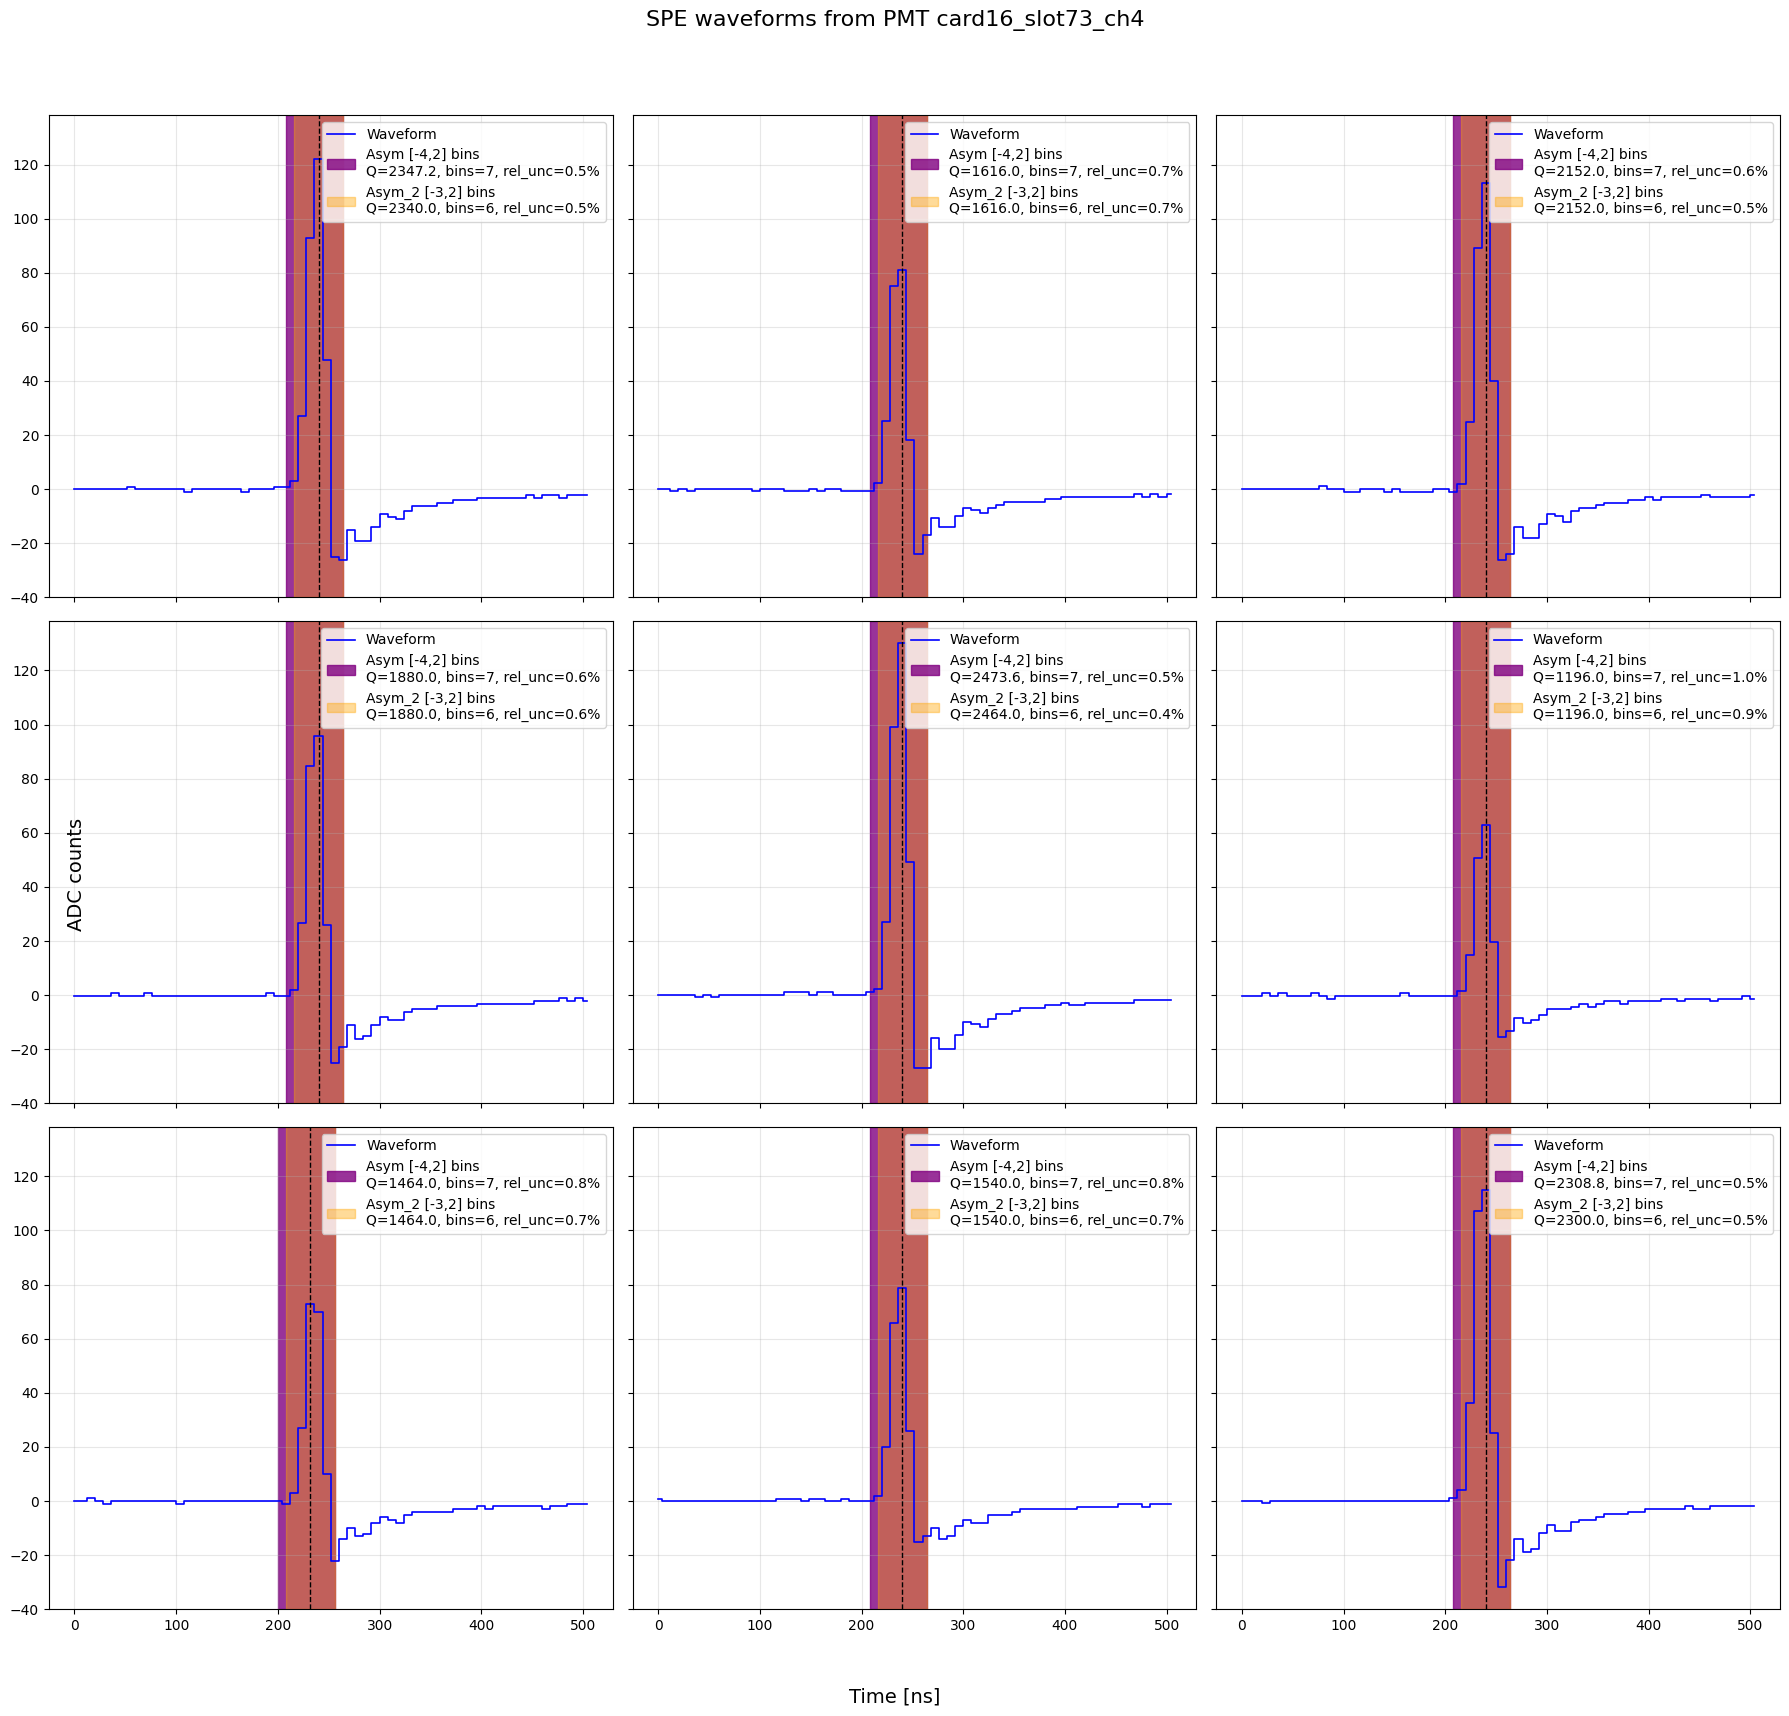

In [14]:
asym_window = (-4, +2)   
asym_window_2 = (-3, +2)    


sigma_sample = np.std(control_waveforms[:, :20])  # adjust baseline region if needed

n_rows, n_cols = 3,3
n_waveforms = n_rows * n_cols
threshold = 50  # ADC counts

valid_indices = [i for i, wf in enumerate(signal_waveforms) if np.max(wf) > threshold]


indices = np.random.choice(valid_indices, n_waveforms, replace=False)

fig, axes = plt.subplots(n_rows, n_cols, figsize=(18, 18), sharex=True, sharey=True)

for ax, idx in zip(axes.flat, indices):
    wf = signal_waveforms[idx]
    peak_idx = int(np.argmax(wf))
    
    #Asymmetric window
    start_asym = max(0, peak_idx + asym_window[0])
    end_asym   = min(len(wf), peak_idx + asym_window[1] + 1)
    bins_asym = end_asym - start_asym
    Q_asym = np.sum(np.clip(wf[start_asym:end_asym], 0, None)) * bin_width
    sigma_Q_asym = np.sqrt(bins_asym) * sigma_sample * bin_width
    rel_unc_asym = sigma_Q_asym / Q_asym * 100 if Q_asym > 0 else np.nan
    
    #Asymmetric window 2 
    start_asym_2 = max(0, peak_idx + asym_window_2[0])
    end_asym_2   = min(len(wf), peak_idx + asym_window_2[1] + 1)
    bins_asym_2 = end_asym_2 - start_asym_2
    Q_asym_2 = np.sum(np.clip(wf[start_asym_2:end_asym_2], 0, None)) * bin_width
    sigma_Q_asym_2 = np.sqrt(bins_asym_2) * sigma_sample * bin_width
    rel_unc_asym_2 = sigma_Q_asym_2 / Q_asym_2 * 100 if Q_asym_2 > 0 else np.nan
    
    ax.plot(time_axis, wf, drawstyle="steps-mid", lw=1.2, color="blue", label="Waveform")
    ax.axvline(peak_idx * bin_width, color="k", linestyle="--", lw=1)
   
    ax.axvspan(time_axis[start_asym], time_axis[end_asym-1] + bin_width,
               alpha=0.8, color="purple", label=(
                   f"Asym [{asym_window[0]},{asym_window[1]}] bins\n"
                   f"Q={Q_asym:.1f}, bins={bins_asym}, rel_unc={rel_unc_asym:.1f}%"))
    
    ax.axvspan(time_axis[start_asym_2], time_axis[end_asym_2-1] + bin_width,
               alpha=0.4, color="orange", label=(
                   f"Asym_2 [{asym_window_2[0]},{asym_window_2[1]}] bins\n"
                   f"Q={Q_asym_2:.1f}, bins={bins_asym_2}, rel_unc={rel_unc_asym_2:.1f}%"))
    
    ax.legend(fontsize=10, loc="upper right")
    ax.grid(alpha=0.3)

fig.text(0.5, 0.04, "Time [ns]", ha="center", fontsize=14)
fig.text(0.04, 0.5, "ADC counts", va="center", rotation="vertical", fontsize=14)
fig.suptitle(f"SPE waveforms from PMT {pmt_label}", fontsize=16)
plt.tight_layout(rect=[0, 0.07, 1, 0.95])
plt.show()

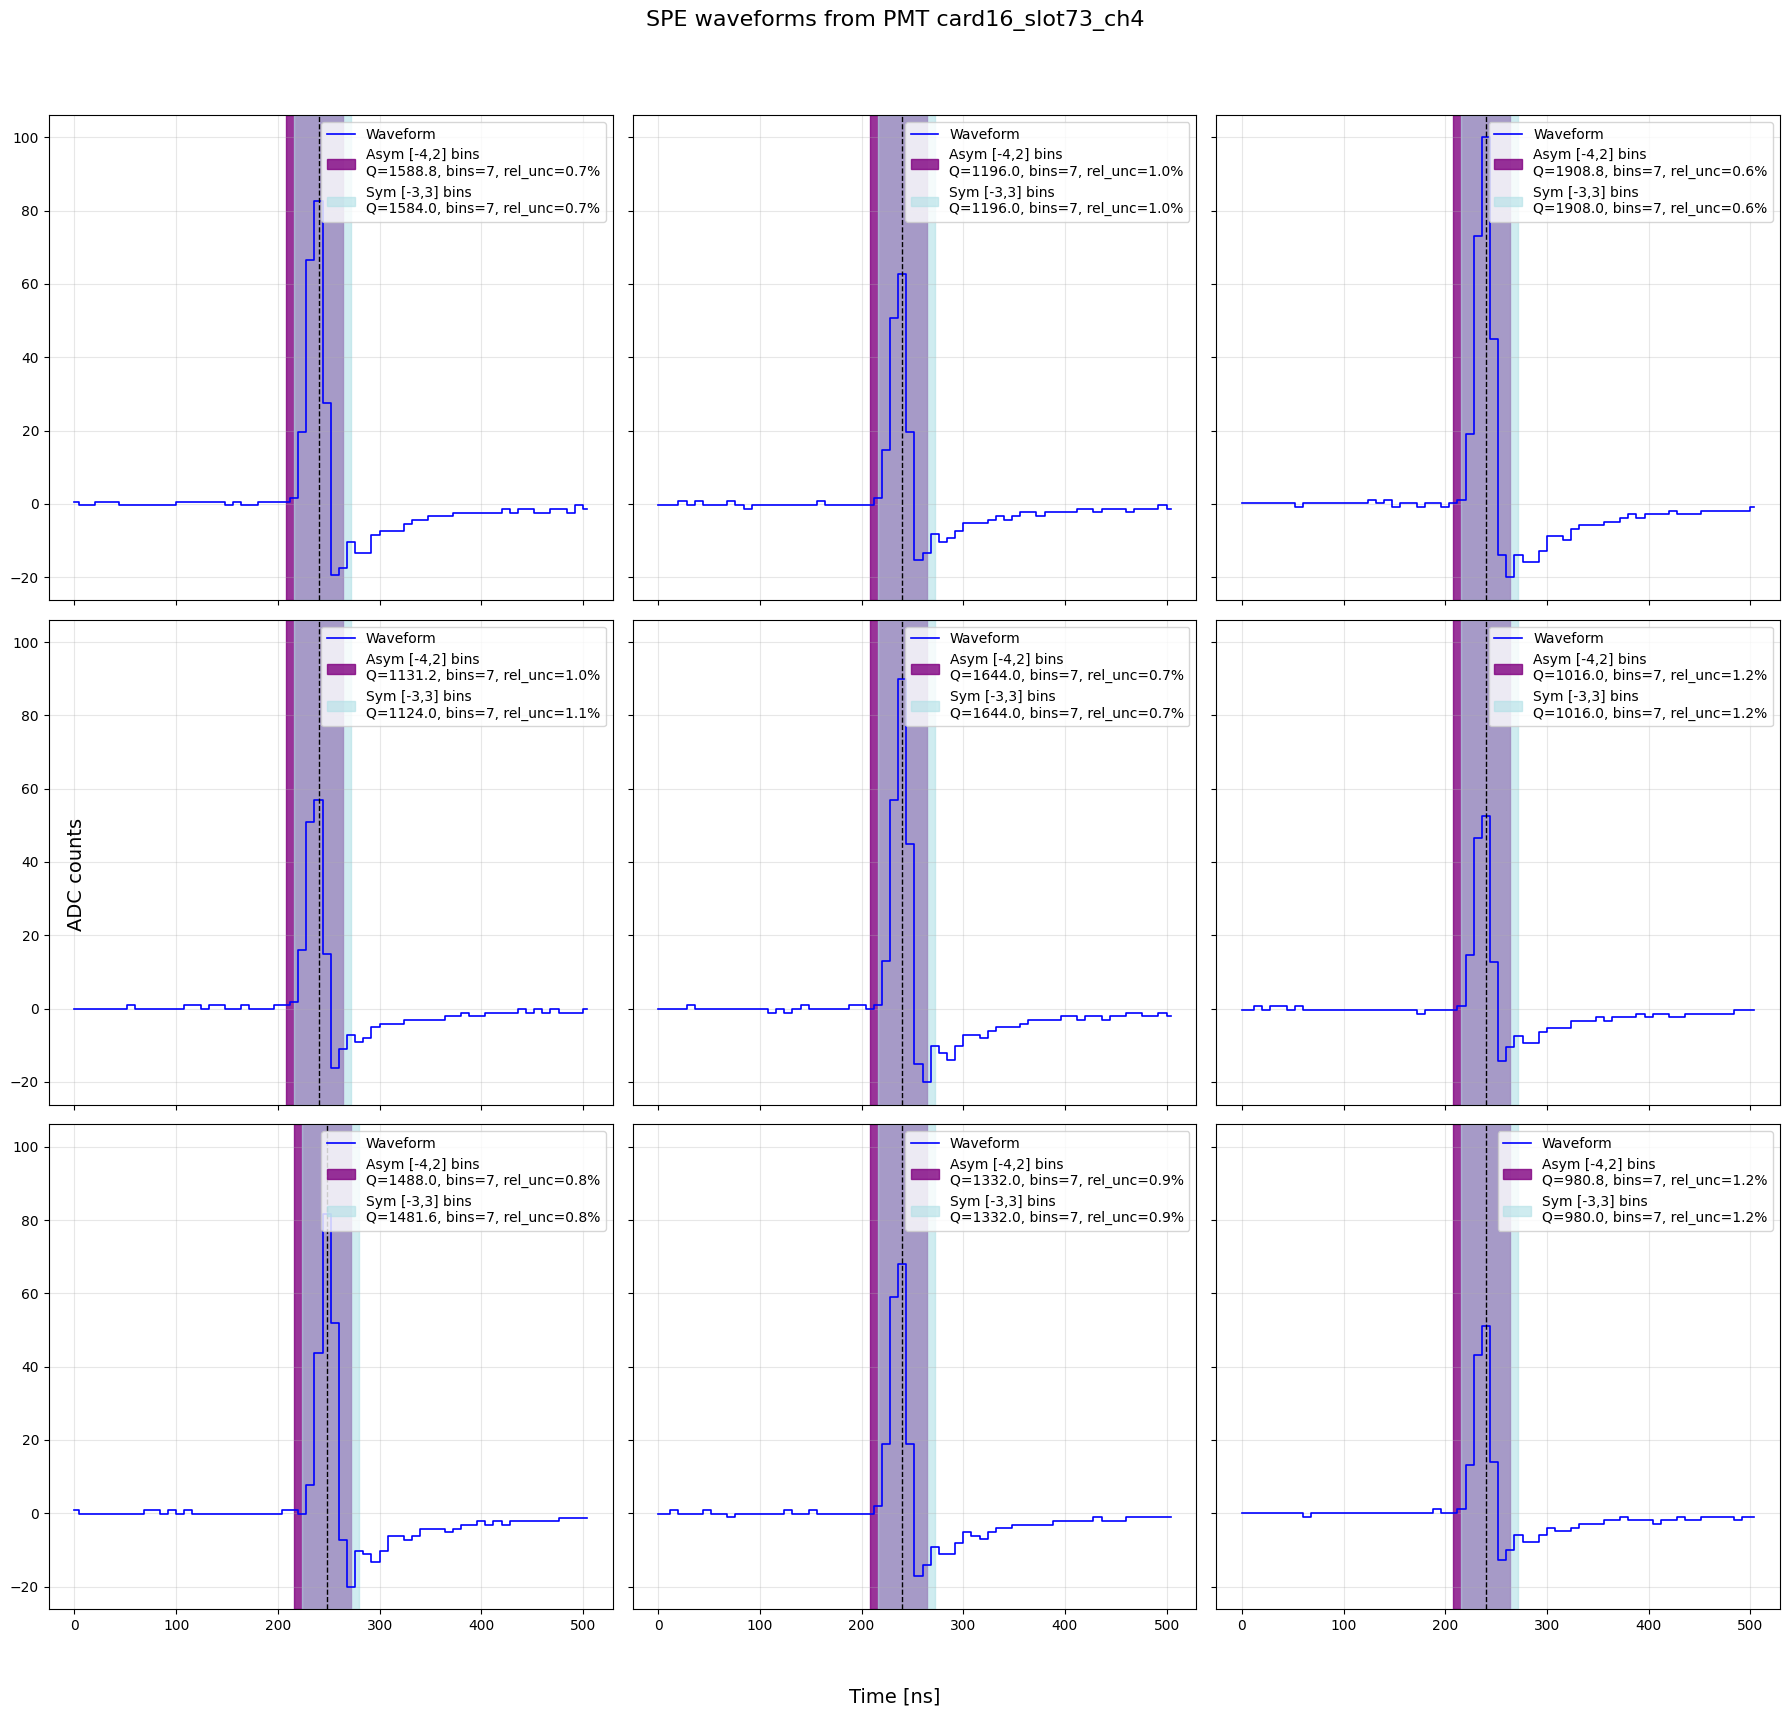

In [15]:
asym_window = (-4, +2)   
symmetric_window = (-3, +3)   

sigma_sample = np.std(control_waveforms[:, :20])  

n_rows, n_cols = 3,3
n_waveforms = n_rows * n_cols
threshold = 50  # ADC counts

valid_indices = [i for i, wf in enumerate(signal_waveforms) if np.max(wf) > threshold]

#different random waveforms every run
indices = np.random.choice(valid_indices, n_waveforms, replace=False)

fig, axes = plt.subplots(n_rows, n_cols, figsize=(18, 18), sharex=True, sharey=True)

for ax, idx in zip(axes.flat, indices):
    wf = signal_waveforms[idx]
    peak_idx = int(np.argmax(wf))
    
    #Asymmetric window
    start_asym = max(0, peak_idx + asym_window[0])
    end_asym   = min(len(wf), peak_idx + asym_window[1] + 1)
    bins_asym = end_asym - start_asym
    Q_asym = np.sum(np.clip(wf[start_asym:end_asym], 0, None)) * bin_width
    sigma_Q_asym = np.sqrt(bins_asym) * sigma_sample * bin_width
    rel_unc_asym = sigma_Q_asym / Q_asym * 100 if Q_asym > 0 else np.nan
    
    #Symmetric window
    start_sym = max(0, peak_idx + symmetric_window[0])
    end_sym   = min(len(wf), peak_idx + symmetric_window[1] + 1)
    bins_sym = end_sym - start_sym
    Q_sym = np.sum(np.clip(wf[start_sym:end_sym], 0, None)) * bin_width
    sigma_Q_sym = np.sqrt(bins_sym) * sigma_sample * bin_width
    rel_unc_sym = sigma_Q_sym / Q_sym * 100 if Q_sym > 0 else np.nan
    
    ax.plot(time_axis, wf, drawstyle="steps-mid", lw=1.2, color="blue", label="Waveform")
    ax.axvline(peak_idx * bin_width, color="k", linestyle="--", lw=1)
   
    ax.axvspan(time_axis[start_asym], time_axis[end_asym-1] + bin_width,
               alpha=0.8, color="purple", label=(
                   f"Asym [{asym_window[0]},{asym_window[1]}] bins\n"
                   f"Q={Q_asym:.1f}, bins={bins_asym}, rel_unc={rel_unc_asym:.1f}%"))
    
    ax.axvspan(time_axis[start_sym], time_axis[end_sym-1] + bin_width,
               alpha=0.6, color="powderblue", label=(
                   f"Sym [{symmetric_window[0]},{symmetric_window[1]}] bins\n"
                   f"Q={Q_sym:.1f}, bins={bins_sym}, rel_unc={rel_unc_sym:.1f}%"))
    
    ax.legend(fontsize=10, loc="upper right")
    ax.grid(alpha=0.3)

fig.text(0.5, 0.04, "Time [ns]", ha="center", fontsize=14)
fig.text(0.04, 0.5, "ADC counts", va="center", rotation="vertical", fontsize=14)
fig.suptitle(f"SPE waveforms from PMT {pmt_label}", fontsize=16)
plt.tight_layout(rect=[0, 0.07, 1, 0.95])
plt.show()

- Cada trigger → una waveform de 64 samples (cada sample = 8 ns).

- Cada sample está en ADC counts (digitalización de la señal analógica del PMT).

Queremos medir el gain de cada PMT, es decir:


$$
G = \frac{Q_{\text{1 p.e.}}}{e}
$$

donde $Q_{\text{1 p.e.}}$ es la carga promedio de un solo fotoelectrón y $e$ es la carga elemental.



Pero en tu DAQ, no tienes directamente Coulombs, sino ADC counts.

Lo que hacemos para relacionarlas: 

Cada waveform → se integra (suma de samples × ancho de bin) para obtener una carga total en ADC·ns.

Esto es equivalente a medir el área del pulso. Esa área es proporcional a la carga real colectada en el ánodo del PMT.

Luego, haces un histograma de todas esas cargas (de un LED run). Verás un pedestal (0 p.e.), un primer pico (1 p.e.), y a veces un segundo pico (2 p.e.) si tienes buena estadística.

In [16]:
signal_dir = "/scratch/elena/WCTE_DATA_ANALYSIS/waveform_npz/run2521/"
control_dir = "/scratch/elena/WCTE_DATA_ANALYSIS/waveform_npz/run2519/"

signal_files = [f for f in os.listdir(signal_dir) if f.endswith(".npz")]
control_files = [f for f in os.listdir(control_dir) if f.endswith(".npz")]

signal_pmts = set(f.replace(".npz", "") for f in signal_files)
control_pmts = set(f.replace(".npz", "") for f in control_files)

pmts_both = sorted(list(signal_pmts & control_pmts))

print(f"Number of PMTs in both files: {len(pmts_both)}")
print("Some examples:", pmts_both[:20])

Number of PMTs in both files: 1548
Some examples: ['card100_slot24_ch0', 'card100_slot24_ch1', 'card100_slot24_ch10', 'card100_slot24_ch11', 'card100_slot24_ch12', 'card100_slot24_ch13', 'card100_slot24_ch14', 'card100_slot24_ch15', 'card100_slot24_ch16', 'card100_slot24_ch17', 'card100_slot24_ch18', 'card100_slot24_ch2', 'card100_slot24_ch3', 'card100_slot24_ch4', 'card100_slot24_ch5', 'card100_slot24_ch6', 'card100_slot24_ch7', 'card100_slot24_ch8', 'card100_slot24_ch9', 'card101_slot20_ch0']


In [17]:
card_id = 100
slot_id = 24
channel_id = 16

pmt_label = f"card{card_id}_slot{slot_id}_ch{channel_id}"

signal_npz = f"/scratch/elena/WCTE_DATA_ANALYSIS/waveform_npz/run2521/{pmt_label}.npz"    #signal run2521
control_npz = f"/scratch/elena/WCTE_DATA_ANALYSIS/waveform_npz/run2519/{pmt_label}.npz"   #control run2519

In [18]:
signal_npz = os.path.join(signal_dir, pmt_label + ".npz")
control_npz = os.path.join(control_dir, pmt_label + ".npz")


pre_peak   = 4   # bins before max (for SPE)
post_peak  = 1   # bins after max (for SPE)
ped_window = 4   # symmetric window width (for pedestal)

def load_waveforms(npz_file):
    data = np.load(npz_file)
    return data["waveforms"]

signal_waveforms = load_waveforms(signal_npz)
control_waveforms = load_waveforms(control_npz)

def integrate_waveform_signal(wf, pre_peak=pre_peak, post_peak=post_peak):
    peak_idx = np.argmax(wf)
    start = max(0, peak_idx - pre_peak)
    end   = min(len(wf), peak_idx + post_peak + 1)
    return np.sum(wf[start:end])

def integrate_waveform_control(wf, window=ped_window):
    peak_idx = np.argmax(wf)
    half_w = window // 2
    start = max(0, peak_idx - half_w)
    end   = min(len(wf), peak_idx + half_w)
    return np.sum(wf[start:end])

charges_signal = np.array([integrate_waveform_signal(wf) for wf in signal_waveforms])
charges_control = np.array([integrate_waveform_control(wf) for wf in control_waveforms])



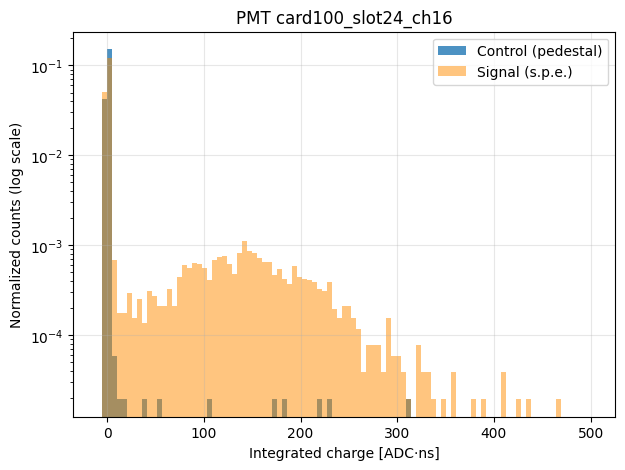

In [19]:
plt.figure(figsize=(7,5))
bins = np.linspace(-10, 500, 100)

plt.hist(charges_control, bins=bins, color = "#1f77b4", alpha=0.8, label="Control (pedestal)", density=True)
plt.hist(charges_signal, bins=bins, color="darkorange", alpha=0.5, label="Signal (s.p.e.)", density=True)

plt.yscale("log")
plt.xlabel("Integrated charge [ADC·ns]")
plt.ylabel("Normalized counts (log scale)")
plt.legend()
plt.grid(alpha=0.3)
plt.title(f"PMT {pmt_label}")
plt.show()

In [20]:
# NLL

def stable_nll(params, data):
    mu1, sigma1, mu2, sigma2, w = params
    if sigma1 <= 0 or sigma2 <= 0:    #sigma > 0, w in (0,1)
        return 1e300
    #clip w away from 0/1 for log stability
    w = float(np.clip(w, 1e-9, 1-1e-9))
    #logpdfs
    lp1 = norm.logpdf(data, loc=mu1, scale=sigma1)
    lp2 = norm.logpdf(data, loc=mu2, scale=sigma2)
    # log of mixture pdf: log( w*exp(lp1) + (1-w)*exp(lp2) ) = logsumexp( log(w)+lp1, log(1-w)+lp2 )
    a = np.log(w) + lp1
    b = np.log(1.0 - w) + lp2
    #use numpy logaddexp for stable log-sum-exp elementwise
    lpmix = np.logaddexp(a, b)
    #negative log-likelihood
    return -np.sum(lpmix)


#try multiple random starts

def fit_double_gauss_multistart(data, n_starts=12, verbose=True):
    best = None
    best_nll = np.inf

    #sensible heuristics from data
    p10, p30, p50, p70, p90 = np.percentile(data, [10,30,50,70,90])     #percentiles
    spe_candidates = data[(data>80) & (data<200)]
    mu2_guess = np.median(spe_candidates) if len(spe_candidates)>0 else p70

    #grid of initial guesses (small grid + some random perturbations)
    init_list = []
    mus1 = [0.0, p10, p30]
    mus2 = [mu2_guess, p70, p90]
    sigs = [3.0, 10.0, 20.0]
    ws = [0.1, 0.3, 0.5]

    for mu1 in mus1:
        for mu2 in mus2:
            for s1 in sigs:
                for s2 in sigs:
                    for w in ws:
                        init_list.append([mu1, s1, mu2, s2, w])
                        if len(init_list) >= n_starts:
                            break
                    if len(init_list) >= n_starts: break
                if len(init_list) >= n_starts: break
            if len(init_list) >= n_starts: break
        if len(init_list) >= n_starts: break

    #if still fewer than requested, add random inits
    rng = np.random.default_rng(12345)
    while len(init_list) < n_starts:
        mu1_r = float(rng.normal(loc=0.0, scale=5.0))
        mu2_r = float(rng.uniform(p50, p90+20))
        s1_r = float(rng.uniform(1.0, 15.0))
        s2_r = float(rng.uniform(5.0, 40.0))
        w_r  = float(rng.uniform(0.01, 0.9))
        init_list.append([mu1_r, s1_r, mu2_r, s2_r, w_r])

    bounds = [(-50, 50), (0.1, 100), ( -10, 500), (0.1, 200), (1e-6, 1-1e-6)]

    for i, p0 in enumerate(init_list):
        res = minimize(stable_nll, p0, args=(data,), method="L-BFGS-B", bounds=bounds,
                       options={'maxiter':1000})
        if not res.success and verbose:
            #keep trying, but print a short message
            pass
        if res.fun < best_nll:
            best_nll = res.fun
            best = res

    if best is None:
        raise RuntimeError("No successful fit found.")
    #reorder so mu1 < mu2 (pedestal = component with smaller mean)
    mu1f, s1f, mu2f, s2f, wf = best.x
    if mu1f > mu2f:
        #swap components
        mu1f, mu2f = mu2f, mu1f
        s1f, s2f = s2f, s1f
        wf = 1.0 - wf

    #attach diagnostics
    out = {
        'mu1': mu1f, 'sigma1': s1f, 'mu2': mu2f, 'sigma2': s2f, 'w': wf,
        'nll': best.fun, 'success': best.success, 'message': best.message, 'result_obj': best
    }
    if verbose:
        print("Best fit status:", out['success'], "-", out['message'])
        print(f"Negative log-likelihood: {out['nll']:.3f}")
    return out


#Run fit in data
fit_res = fit_double_gauss_multistart(charges_signal, n_starts=15, verbose=True)

mu1, sigma1, mu2, sigma2, w = fit_res['mu1'], fit_res['sigma1'], fit_res['mu2'], fit_res['sigma2'], fit_res['w']

print("\nFit final:")
print(f"mu1={mu1:.3f}, sigma1={sigma1:.3f}, mu2={mu2:.3f}, sigma2={sigma2:.3f}, w={w:.4f}")

Best fit status: True - CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH
Negative log-likelihood: 22162.172

Fit final:
mu1=0.674, sigma1=0.855, mu2=135.384, sigma2=81.872, w=0.8720


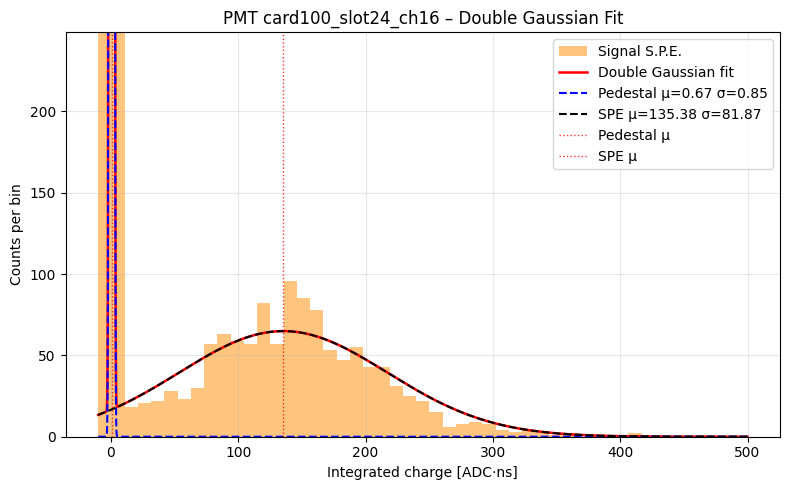

In [21]:
def double_gauss_pdf(x, mu1, sigma1, mu2, sigma2, w):
    return w * norm.pdf(x, mu1, sigma1) + (1-w) * norm.pdf(x, mu2, sigma2)

plt.figure(figsize=(8,5))
bins = np.linspace(-10, 500, 50)

#Raw counts
counts, bins, _ = plt.hist(charges_signal, bins=bins, color="darkorange", alpha=0.5, label="Signal S.P.E.", density=False)

bin_width = bins[1] - bins[0]
N = len(charges_signal)

x_vals = np.linspace(-10, 500, 2000)
pdf_total = double_gauss_pdf(x_vals, mu1, sigma1, mu2, sigma2, w)
pdf_ped   = w * norm.pdf(x_vals, mu1, sigma1)
pdf_spe   = (1-w) * norm.pdf(x_vals, mu2, sigma2)

pdf_total_counts = pdf_total * N * bin_width
pdf_ped_counts   = pdf_ped   * N * bin_width
pdf_spe_counts   = pdf_spe   * N * bin_width

plt.plot(x_vals, pdf_total_counts, 'r-', lw=1.8, label="Double Gaussian fit")
plt.plot(x_vals, pdf_ped_counts, 'b--', lw=1.5, label=f"Pedestal μ={mu1:.2f} σ={sigma1:.2f}")
plt.plot(x_vals, pdf_spe_counts, 'k--', lw=1.5, label=f"SPE μ={mu2:.2f} σ={sigma2:.2f}")

#Líneas verticales punteadas rojas para medias
plt.axvline(mu1, color='red', linestyle=':', lw=1, alpha=0.8, label=f"Pedestal μ")
plt.axvline(mu2, color='red', linestyle=':', lw=1, alpha=0.8, label=f"SPE μ")

plt.ylim(0, np.max(counts)*0.05)   # limita el eje y para ver el SPE
plt.xlabel("Integrated charge [ADC·ns]")
plt.ylabel("Counts per bin")
plt.title(f"PMT {pmt_label} – Double Gaussian Fit")
plt.grid(alpha=0.3, which='both')
plt.legend()
plt.tight_layout()
plt.show()

# NEW ANALYSIS

In [1]:
import uproot
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm
from scipy.optimize import minimize
from tqdm import tqdm
import random
import os
import re


path = "/scratch/elena/WCTE_DATA_ANALYSIS/WCTE_MC-Data_Validation_with_GAIN_Calibration/root_files/WCTE_offline_R2307S0P0.root"  
#2307 810ns
#2308 820ns
#2309 830ns
#2311 850ns
#2312 900ns 


print("Opening file...")
f = uproot.open(path)
print("File opened successfully!")

print("Available keys in file:")
print(f.keys())

tree = f["WCTEReadoutWindows"]
print("Tree opened successfully!")

print("Number of entries:", tree.num_entries)
print("Branch names:")
print(tree.keys())

Opening file...
File opened successfully!
Available keys in file:
['WCTEReadoutWindows;35', 'WCTEReadoutWindows;34']
Tree opened successfully!
Number of entries: 17784
Branch names:
['window_time', 'start_counter', 'run_id', 'sub_run_id', 'spill_counter', 'event_number', 'readout_number', 'trigger_types', 'trigger_times', 'led_gains', 'led_dacsettings', 'led_ids', 'led_card_ids', 'led_slot_numbers', 'led_event_types', 'led_types', 'led_sequence_numbers', 'led_counters', 'hit_mpmt_card_ids', 'hit_pmt_channel_ids', 'hit_mpmt_slot_ids', 'hit_pmt_position_ids', 'hit_pmt_charges', 'hit_pmt_times', 'pmt_waveform_mpmt_card_ids', 'pmt_waveform_pmt_channel_ids', 'pmt_waveform_mpmt_slot_ids', 'pmt_waveform_pmt_position_ids', 'pmt_waveform_times', 'pmt_waveforms', 'beamline_pmt_qdc_charges', 'beamline_pmt_tdc_times', 'beamline_pmt_qdc_ids', 'beamline_pmt_tdc_ids']


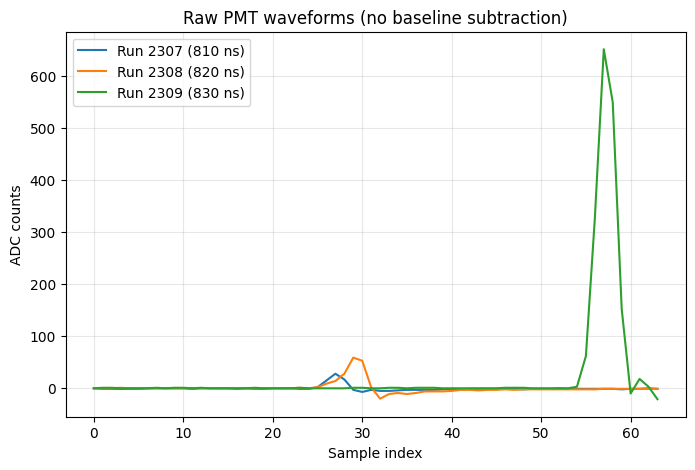

In [54]:
pulse_widths = {2307: 810, 2308: 820, 2309: 830}

plt.figure(figsize=(8,5))

for run, width in pulse_widths.items():
    path = f"/scratch/elena/WCTE_DATA_ANALYSIS/WCTE_MC-Data_Validation_with_GAIN_Calibration/root_files/WCTE_offline_R{run}S0P0.root"
    tree = uproot.open(f"{path}:WCTEReadoutWindows")
    
    # Read first few events to look at raw waveforms
    data = tree.arrays(["pmt_waveforms"], entry_start=0, entry_stop=50, library="ak")

    # Loop over events and pick a waveform that looks like it contains a pulse
    found = False
    for evt in range(len(data["pmt_waveforms"])):
        wfs_evt = data["pmt_waveforms"][evt]
        if len(wfs_evt) == 0:
            continue
        wf = np.array(wfs_evt[0])
        if wf.max() > 20:  # signal threshold (adjust if needed)
            plt.plot(wf, label=f"Run {run} ({width} ns)")
            found = True
            break

    if not found:
        print(f"No waveform with visible pulse found in run {run}")

plt.xlabel("Sample index")
plt.ylabel("ADC counts")
plt.title("Raw PMT waveforms (no baseline subtraction)")
plt.legend()
plt.grid(alpha=0.3)
plt.show()


In [24]:
import uproot
import numpy as np
import awkward as ak
import matplotlib.pyplot as plt
import random

def do_pulse_finding(waveform):
    threshold = max(0.02 * np.max(waveform), 10)
    fIntegralPreceding, fIntegralFollowing = 4, 2
    above_threshold = np.where(waveform[3:-2] > threshold)[0] + 3
    pulses_found, last_index = [], 0
    for index in above_threshold:
        if (waveform[index] <= waveform[index-1]): continue
        if (waveform[index] < waveform[index+1]): continue
        if (waveform[index] <= waveform[index+2]): continue
        if (waveform[index] <= waveform[index-2]): continue
        start = max(0, index - fIntegralPreceding)
        end = min(len(waveform), index + fIntegralFollowing + 1)
        integral = np.sum(waveform[start:end])
        if integral < threshold * 2: continue
        if (last_index > 0) and (index - last_index) <= 20: continue
        pulses_found.append(index)
        last_index = index
    return pulses_found

def charge_calculation_mPMT_method(wf, peak_sample):
    n = len(wf)
    start = max(0, peak_sample - 5)
    end = min(n, peak_sample + 2)
    charge = np.sum(wf[start:end])
    if peak_sample + 2 < n and wf[peak_sample + 2] > 0:
        charge += wf[peak_sample + 2]
    return charge, start, end

# -------------------------------
# Define runs and colors
runs = {
    2307: {"color": "gold", "width": 810},
    2308: {"color": "magenta", "width": 820},
    2309: {"color": "limegreen", "width": 830},
    2313: {"color": "cyan", "width": 900}
}

plt.figure(figsize=(10, 6))

# -------------------------------
# Load first 500 events from all runs
data_dict = {}
for run in runs:
    path = f"/scratch/elena/WCTE_DATA_ANALYSIS/WCTE_MC-Data_Validation_with_GAIN_Calibration/root_files/WCTE_offline_R{run}S0P0.root"
    tree = uproot.open(f"{path}:WCTEReadoutWindows")
    data_dict[run] = tree.arrays(["pmt_waveforms"], entry_start=0, entry_stop=500, library="ak")

# -------------------------------
# Collect all PMTs that are good in ALL runs
good_candidates = []
min_events = min(len(data_dict[r]["pmt_waveforms"]) for r in runs)

for evt_idx in range(min_events):
    pmts_in_evt = min(len(data_dict[r]["pmt_waveforms"][evt_idx]) for r in runs)
    for pmt_idx in range(pmts_in_evt):
        valid = True
        for run in runs:
            wf = np.array(data_dict[run]["pmt_waveforms"][evt_idx][pmt_idx])
            if len(wf) < 10 or np.std(wf) < 1:
                valid = False
                break
        if valid:
            good_candidates.append((evt_idx, pmt_idx))

if not good_candidates:
    raise RuntimeError("❌ No PMTs with good waveforms in all runs found.")

# Randomly pick one PMT
fixed_evt_idx, fixed_pmt_idx = random.choice(good_candidates)
print(f"🎯 Randomly selected PMT {fixed_pmt_idx} from event {fixed_evt_idx} (common to all runs)")

# -------------------------------
# Plot waveforms
for run, info in runs.items():
    color = info["color"]
    width = info["width"]

    wfs_evt = data_dict[run]["pmt_waveforms"][fixed_evt_idx]
    wf = np.array(wfs_evt[fixed_pmt_idx])

    peaks = do_pulse_finding(wf)
    if not peaks:
        print(f"⚠️ Run {run}: no pulse found.")
        continue

    peak = peaks[0]
    charge, start, end = charge_calculation_mPMT_method(wf, peak)

    # Plot waveform
    plt.plot(wf, color=color, label=f"Run {run} ({width} ns)")

    # Shade integration window
    plt.axvspan(start, end, color=color, alpha=0.2)

    # Mark integration limits and peak (in legend only)
    label_info = (f"start_window={start}, "
                  f"end_window={end}, "
                  f"peak_bin={peak}")
    plt.plot([], [], color=color, lw=0, label=label_info)

    print(f"✅ run {run}: PMT={fixed_pmt_idx}, peak={peak}, "
          f"window=[{start},{end}], charge={charge:.1f}, max={np.max(wf):.1f}")

# -------------------------------
plt.xlabel("bins", fontsize=10)
plt.ylabel("ADC counts", fontsize=10)
plt.title(f"Waveforms for PMT {fixed_pmt_idx}", fontsize=14)
plt.legend(fontsize=8, loc="upper right", framealpha=0.9)
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

KeyboardInterrupt: 

<Figure size 1000x600 with 0 Axes>

In [2]:
#signal_dir = "/scratch/elena/WCTE_DATA_ANALYSIS/waveform_npz/run2309"

signal_dir = "/scratch/elena/WCTE_DATA_ANALYSIS/waveform_npz/run2307"

pattern = re.compile(r"card(\d+)_slot(\d+)_ch(\d+)\.npz$")

available_combinations = []

for fname in os.listdir(signal_dir):
    match = pattern.match(fname)
    if match:
        card_id, slot_id, ch_id = map(int, match.groups())
        available_combinations.append((card_id, slot_id, ch_id))

#pick 20 random combinations (different every time)
n_samples = 20      
if len(available_combinations) > n_samples:
    random_combinations = np.random.choice(len(available_combinations), size=n_samples, replace=False)
    selected_combinations = [available_combinations[i] for i in random_combinations]
else:
    selected_combinations = available_combinations  # if fewer than 20 total

print(f"Found {len(available_combinations)} valid waveform files.")
print(f"Showing {len(selected_combinations)} random combinations:\n")
for card, slot, ch in selected_combinations:
    print(f"  card={card:02d}, slot={slot:03d}, ch={ch}")

Found 1567 valid waveform files.
Showing 20 random combinations:

  card=108, slot=003, ch=11
  card=34, slot=078, ch=0
  card=111, slot=097, ch=7
  card=12, slot=001, ch=2
  card=102, slot=022, ch=7
  card=23, slot=047, ch=8
  card=109, slot=104, ch=9
  card=17, slot=029, ch=2
  card=03, slot=068, ch=8
  card=25, slot=062, ch=4
  card=32, slot=075, ch=9
  card=101, slot=020, ch=18
  card=115, slot=057, ch=6
  card=100, slot=024, ch=10
  card=26, slot=060, ch=16
  card=85, slot=093, ch=0
  card=16, slot=073, ch=13
  card=10, slot=061, ch=6
  card=46, slot=004, ch=12
  card=107, slot=044, ch=11


In [3]:
card_id, slot_id, channel_id = random.choice(available_combinations)

print(f"Randomly selected PMT: card={card_id}, slot={slot_id}, ch={channel_id}")

pmt_label = f"card{card_id}_slot{slot_id}_ch{channel_id}"
signal_npz = os.path.join(signal_dir, pmt_label + ".npz")


def load_waveforms(npz_file):
    data = np.load(npz_file)
    return data["waveforms"]

signal_waveforms = load_waveforms(signal_npz)
print("Loaded signal waveforms:", signal_waveforms.shape)

Randomly selected PMT: card=75, slot=95, ch=13
Loaded signal waveforms: (17784, 64)


In [4]:
#functions for WCTE consistency!

def do_pulse_finding(waveform, debug=False):
    #threshold = max(0.02 * np.max(waveform), 10)
    threshold = 20
    fIntegralPreceding = 4
    fIntegralFollowing = 2
    
    above_threshold = np.where(waveform[3:-2] > threshold)[0] + 3
    pulses_found = []
    last_index = 0
    
    for index in above_threshold:
        #local maximum conditions
        if (waveform[index] <= waveform[index-1]): continue
        if (waveform[index] < waveform[index+1]): continue
        if (waveform[index] <= waveform[index+2]): continue
        if (waveform[index] <= waveform[index-2]): continue
        
        #integral condition
        start = max(0, index - fIntegralPreceding)
        end = min(len(waveform), index + fIntegralFollowing + 1)
        integral = np.sum(waveform[start:end])
        if integral < threshold * 2:
            continue
        
        #minimum spacing conditions between pulses
        if (last_index > 0) and (index - last_index) <= 20:
            continue
        
        pulses_found.append(index)
        last_index = index
    
    return pulses_found


def charge_calculation_mPMT_method(wf, peak_sample):
    n = len(wf)
    if peak_sample < 5 or peak_sample + 2 >= n:
        pass
    start = max(0, peak_sample - 5)
    end = min(n, peak_sample + 2)
    charge = np.sum(wf[start:end])
    if peak_sample + 2 < n and wf[peak_sample + 2] > 0:
        charge += wf[peak_sample + 2]
    return charge

In [5]:

all_peaks = [do_pulse_finding(wf) for wf in signal_waveforms]
pulse_mask = np.array([len(p) > 0 for p in all_peaks])
noise_mask = ~pulse_mask

charges = []
peak_values = []

pulse_count = np.sum(pulse_mask)
noise_count = np.sum(noise_mask)

for wf, peaks in tqdm(zip(signal_waveforms, all_peaks), 
                      desc="Integrating all waveforms", 
                      total=len(signal_waveforms)):
    if len(peaks) > 0:
        peak_sample = peaks[0]    # pulse waveform
    else:
        peak_sample = np.argmax(wf)  # noise waveform

    q = charge_calculation_mPMT_method(wf, peak_sample)
    charges.append(q)
    peak_values.append(wf[peak_sample])

charges = np.array(charges)
peak_values = np.array(peak_values)


total_waveforms = len(signal_waveforms)
pulse_ratio = pulse_count / total_waveforms

#mean of Poisson statistics
mu = -np.log(1 - pulse_ratio)

# --- Print results ---
print(f"Total waveforms processed: {total_waveforms}")
print(f"Pulses detected (LED): {pulse_count}")
print(f"Noise-only waveforms (pedestal): {noise_count}")
print(f"Pulse-to-LED flash ratio: {pulse_ratio:.4f} ({pulse_ratio*100:.2f}%)")
print(f"Mean number of photoelectrons per LED flash (mu): {mu:.4f}")   #if <<1, we are OK; if ~1, almost every flash would produce a pulse (saturated!)

Integrating all waveforms: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████| 17784/17784 [00:00<00:00, 47555.70it/s]

Total waveforms processed: 17784
Pulses detected (LED): 1193
Noise-only waveforms (pedestal): 16591
Pulse-to-LED flash ratio: 0.0671 (6.71%)
Mean number of photoelectrons per LED flash (mu): 0.0694


In [6]:
print(f"Largest negative charge: {charges.min():.3f} ADC·ns")
print(f"Largest negative charge: {charges.max():.3f} ADC·ns")

Largest negative charge: -8.600 ADC·ns
Largest negative charge: 1569.200 ADC·ns


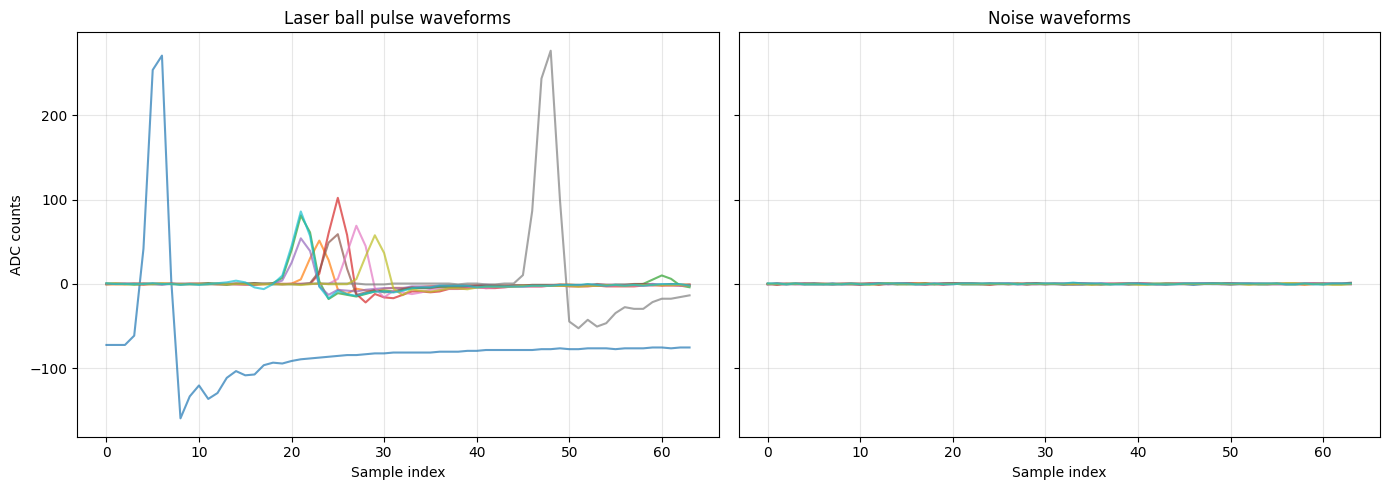

In [7]:
pulse_mask = np.zeros(len(charges), dtype=bool)
noise_mask = np.zeros(len(charges), dtype=bool)

index = 0
for wf in signal_waveforms:
    peaks = do_pulse_finding(wf)
    if len(peaks) > 0:
        pulse_mask[index] = True
    else:
        noise_mask[index] = True
    index += 1

#10 random waveforms for each data set
pulse_indices = np.random.choice(np.where(pulse_mask)[0], size=min(10, np.sum(pulse_mask)), replace=False)
noise_indices = np.random.choice(np.where(noise_mask)[0], size=min(10, np.sum(noise_mask)), replace=False)

fig, axes = plt.subplots(1, 2, figsize=(14, 5), sharey=True)


for idx in pulse_indices:
    axes[0].plot(signal_waveforms[idx], alpha=0.7)    #drawstyle="steps-mid"
axes[0].set_title(f"Laser ball pulse waveforms")
axes[0].set_xlabel("Sample index")
axes[0].set_ylabel("ADC counts")
axes[0].grid(True, alpha=0.3)


for idx in noise_indices:
    axes[1].plot(signal_waveforms[idx], alpha=0.7)
axes[1].set_title(f"Noise waveforms")
axes[1].set_xlabel("Sample index")
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

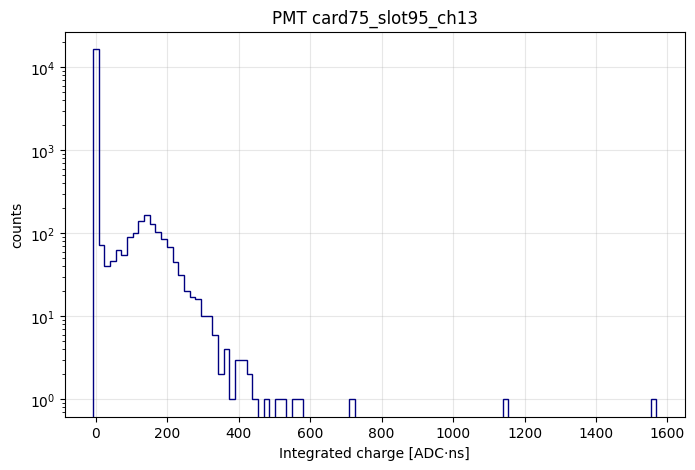

Pulse waveforms: 1193 | Noise waveforms: 16591


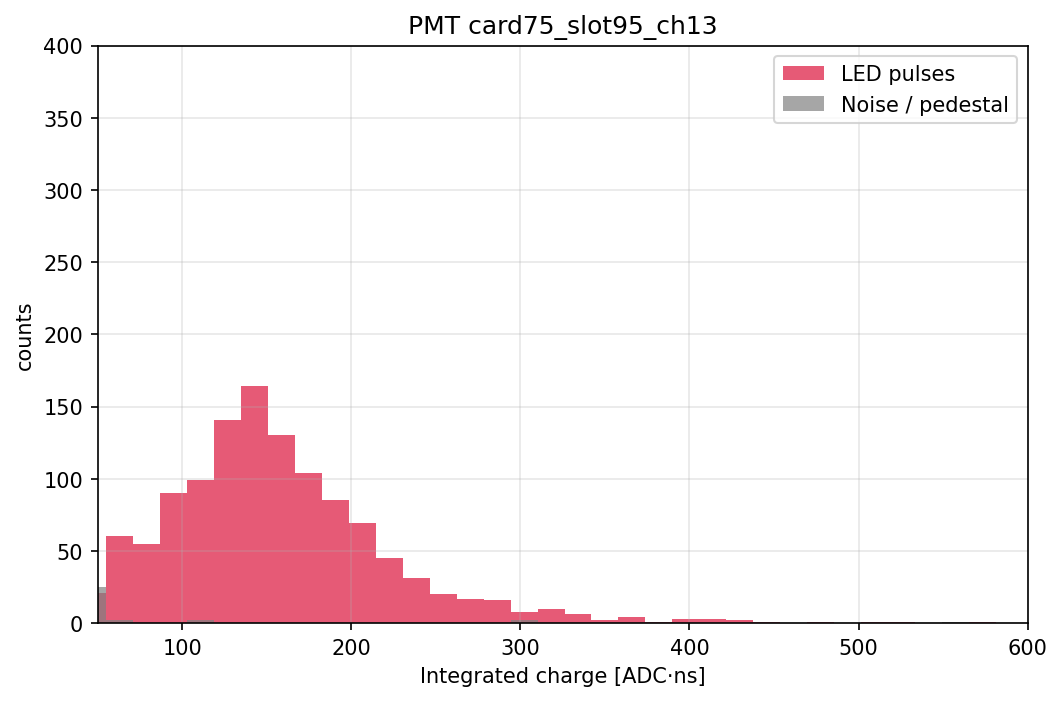

In [8]:
bins = np.linspace(charges.min(), charges.max(), 100)

#total charge distribution (integrated charge)
plt.figure(figsize=(8,5))
plt.hist(charges, bins=bins, histtype='step', color='navy')
plt.xlabel("Integrated charge [ADC·ns]")
plt.ylabel("counts")
plt.yscale("log")
#plt.xlim(-100, 500)
plt.title(f"PMT {pmt_label}")
plt.grid(True, alpha=0.3)
plt.show()


pulse_mask = np.array([len(p) > 0 for p in all_peaks])
noise_mask = ~pulse_mask

print(f"Pulse waveforms: {np.sum(pulse_mask)} | Noise waveforms: {np.sum(noise_mask)}")

plt.figure(figsize=(8,5), dpi=150)
plt.hist(charges[pulse_mask], bins=bins, color='crimson', alpha=0.7, label='LED pulses')
plt.hist(charges[noise_mask], bins=bins, color='gray', alpha=0.7, label='Noise / pedestal')
plt.xlabel("Integrated charge [ADC·ns]")
plt.ylabel("counts")
#plt.yscale("log")
plt.xlim(50, 600)
plt.ylim(0,400)
plt.title(f"PMT {pmt_label}")
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

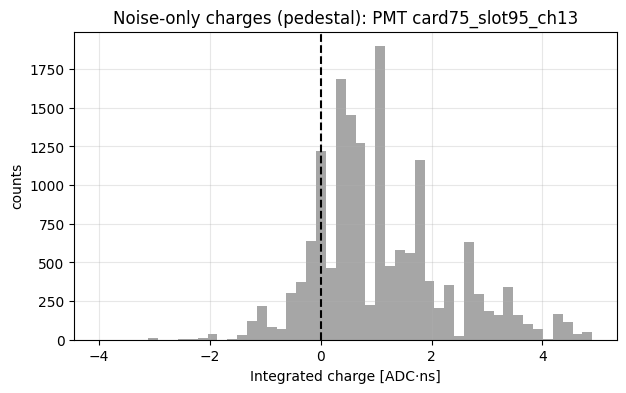

In [9]:
noise_charges = charges[np.abs(charges) < 5]

plt.figure(figsize=(7,4))
plt.hist(noise_charges, bins=50, color='gray', alpha=0.7)
plt.axvline(x=0, color="k", linestyle="--")
plt.xlabel("Integrated charge [ADC·ns]")
plt.ylabel("counts")
plt.title(f"Noise-only charges (pedestal): PMT {pmt_label}")
plt.grid(True, alpha=0.3)
plt.show()

----- Unbinned double Gaussian fit for PMT card7_slot34_ch4 -----
Pedestal (μ₁, σ₁) = (0.80, 1.53) ADC·ns
SPE       (μ₂, σ₂) = (138.34, 50.00) ADC·ns
Weight w = 0.866
Gain (μ₂ - μ₁) = 137.54 ± 50.02 ADC·ns
Negative charges: 2422/17784 (13.62%)


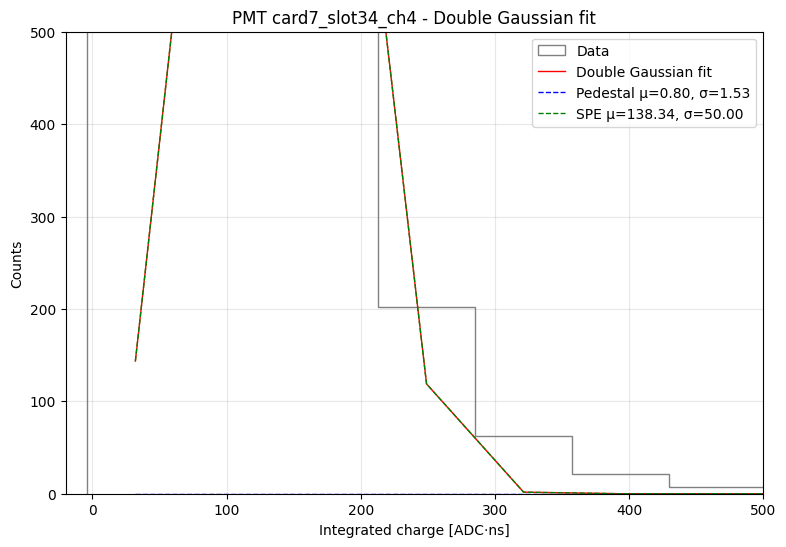

In [10]:
#mu2_guess = np.mean(data[(data >= 125) & (data <= 180)])


from scipy.stats import gaussian_kde
from scipy.signal import argrelextrema

def nll_double_gauss(params, data):
    mu1, sigma1, mu2, sigma2, w = params
    if sigma1 <= 0 or sigma2 <= 0 or not (0 < w < 1):
        return np.inf
    pdf = w * norm.pdf(data, mu1, sigma1) + (1 - w) * norm.pdf(data, mu2, sigma2)
    pdf = np.clip(pdf, 1e-12, None)  # avoid log(0)
    return -np.sum(np.log(pdf))


def fit_double_gauss_unbinned_full(charges, n_starts=50, pmt_label="PMT"):
    data = np.asarray(charges)
    if len(data) < 30:
        raise RuntimeError("Muy pocos puntos para ajustar una doble gaussiana")

    # --- Pedestal initial guesses ---
    mu1_guess = 0.0
    sigma1_guess = np.std(data[data < 10]) if np.any(data < 10) else np.std(data)

    # --- KDE-based SPE peak estimation ---
    kde = gaussian_kde(data)
    xs = np.linspace(data.min(), data.max(), 2000)
    ys = kde(xs)

    peaks = argrelextrema(ys, np.greater)[0]
    sorted_peaks = xs[peaks][np.argsort(ys[peaks])]

    if len(sorted_peaks) >= 2:
        mu2_guess = sorted_peaks[-1]
    else:
        mu2_guess = np.percentile(data, 80)

    sigma2_guess = np.std(data[data > mu2_guess - 20]) if np.any(data > mu2_guess - 20) else 10.0

    # --- Bounds (adaptive) ---
    bounds = [
        (data.min() - 10, np.percentile(data, 40)),   # mu1
        (0.01, 5),                                     # sigma1
        (np.percentile(data, 40), data.max() + 50),   # mu2
        (5, 50),                                       # sigma2
        (0.01, 0.99)                                   # w
    ]

    # --- Initial guesses using improved SPE estimates ---
    mus1 = [mu1_guess]
    sigs1 = [sigma1_guess]
    mus2 = [mu2_guess * 0.9, mu2_guess, mu2_guess * 1.1]  # replaced fixed 130–160
    sigs2 = [sigma2_guess * 0.7, sigma2_guess, sigma2_guess * 1.3]
    ws = [0.1, 0.2, 0.3]

    init_list = []
    for mu1 in mus1:
        for s1 in sigs1:
            for mu2 in mus2:
                for s2 in sigs2:
                    for w in ws:
                        init_list.append([mu1, s1, mu2, s2, w])
                        if len(init_list) >= n_starts:
                            break
                    if len(init_list) >= n_starts: break
                if len(init_list) >= n_starts: break
            if len(init_list) >= n_starts: break
        if len(init_list) >= n_starts: break

    # --- Run minimization ---
    best = None
    best_nll = np.inf
    for p0 in init_list:
        try:
            res = minimize(nll_double_gauss, p0, args=(data,), method="L-BFGS-B", bounds=bounds)
            if res.success and res.fun < best_nll:
                best = res
                best_nll = res.fun
        except Exception:
            continue

    if best is None:
        raise RuntimeError("No fit found (initial guesses may be unphysical)")

    mu1, s1, mu2, s2, w = best.x
    gain = mu2 - mu1
    err_gain = np.sqrt(s1**2 + s2**2)
    n_neg = np.sum(data < 0)

    # --- Output ---
    print(f"----- Unbinned double Gaussian fit for {pmt_label} -----")
    print(f"Pedestal (μ₁, σ₁) = ({mu1:.2f}, {s1:.2f}) ADC·ns")
    print(f"SPE       (μ₂, σ₂) = ({mu2:.2f}, {s2:.2f}) ADC·ns")
    print(f"Weight w = {w:.3f}")
    print(f"Gain (μ₂ - μ₁) = {gain:.2f} ± {err_gain:.2f} ADC·ns")
    print(f"Negative charges: {n_neg}/{len(data)} ({100*n_neg/len(data):.2f}%)")

    return {
        'mu1': mu1, 'sigma1': s1,
        'mu2': mu2, 'sigma2': s2,
        'w': w,
        'gain': gain, 'err_gain': err_gain,
        'nll': best_nll
    }


# --- Plotting section (unchanged) ---
fit = fit_double_gauss_unbinned_full(charges, n_starts=50, pmt_label=f"PMT {pmt_label}")

bins = np.linspace(charges.min(), charges.max(), 100)
bin_centers = 0.5 * (bins[1:] + bins[:-1])
bin_width = bins[1] - bins[0]

pdf_ped = fit["w"] * norm.pdf(bin_centers, fit["mu1"], fit["sigma1"])
pdf_spe = (1 - fit["w"]) * norm.pdf(bin_centers, fit["mu2"], fit["sigma2"])
pdf_total = (pdf_ped + pdf_spe) * len(charges) * bin_width

plt.figure(figsize=(9,6), dpi=100)
plt.hist(charges, bins=bins, histtype='step', color='gray', label='Data', lw=1)
plt.plot(bin_centers, pdf_total, 'r-', lw=1, label='Double Gaussian fit')
plt.plot(bin_centers, pdf_ped * len(charges) * bin_width, 'b--', lw=1,
         label=f'Pedestal μ={fit["mu1"]:.2f}, σ={fit["sigma1"]:.2f}')
plt.plot(bin_centers, pdf_spe * len(charges) * bin_width, 'g--', lw=1,
         label=f'SPE μ={fit["mu2"]:.2f}, σ={fit["sigma2"]:.2f}')

plt.ylim(0,500)
plt.xlim(-20,500)
plt.xlabel("Integrated charge [ADC·ns]")
plt.ylabel("Counts")
plt.title(f"PMT {pmt_label} - Double Gaussian fit")
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()


----- Unbinned double Gaussian fit for PMT card21_slot64_ch12 -----
Pedestal (μ₁, σ₁) = (0.70, 0.96) ADC·ns
SPE      (μ₂, σ₂) = (147.58, 55.00) ADC·ns
Weight w = 0.805
Gain (μ₂ − μ₁) = 146.88 ± 55.01 ADC·ns
Negative charges: 1753/17784 (9.86%)


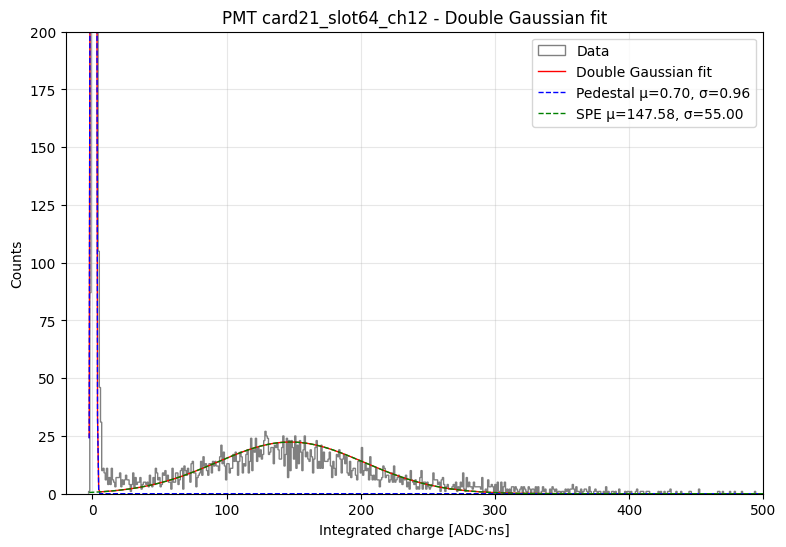

In [72]:
# mu2_guess = np.mean(data[(data >= 125) & (data <= 180)])

from scipy.stats import gaussian_kde
from scipy.signal import argrelextrema

def nll_double_gauss(params, data):
    mu1, sigma1, mu2, sigma2, w = params

    # constraints
    if sigma1 <= 0 or sigma2 <= 0 or not (0 < w < 1):
        return np.inf

    # mixture PDF
    pdf = w * norm.pdf(data, mu1, sigma1) + (1 - w) * norm.pdf(data, mu2, sigma2)
    pdf = np.clip(pdf, 1e-12, None)  # avoid log(0)

    return -np.sum(np.log(pdf))


def fit_double_gauss_unbinned_full(charges, n_starts=50, pmt_label="PMT"):

    data = np.asarray(charges)
    if len(data) < 30:
        raise RuntimeError("Muy pocos puntos para ajustar una doble gaussiana")

    # -----------------------
    # Pedestal initial guesses
    # -----------------------
    mu1_guess = 0.0
    sigma1_guess = np.std(data[data < 10]) if np.any(data < 10) else np.std(data)

    # -----------------------
    # KDE-based SPE estimate
    # -----------------------
    kde = gaussian_kde(data)
    xs = np.linspace(data.min(), data.max(), 2000)
    ys = kde(xs)

    peaks = argrelextrema(ys, np.greater)[0]
    sorted_peaks = xs[peaks][np.argsort(ys[peaks])]

    if len(sorted_peaks) >= 2:
        mu2_guess = sorted_peaks[-1]
    else:
        mu2_guess = np.percentile(data, 80)

    sigma2_guess = np.std(data[data > mu2_guess - 20]) if np.any(data > mu2_guess - 20) else 10.0

    # -----------------------
    # Bounds
    # -----------------------
    bounds = [
        (data.min() - 10, np.percentile(data, 40)),   # mu1
        (0.01, 5),                                    # sigma1
        (np.percentile(data, 40), data.max() + 50),   # mu2
        (5, 55),                                      # sigma2
        (0.01, 0.99)                                  # w
    ]

    # -----------------------
    # Initial guess grid
    # -----------------------
    mus1  = [mu1_guess]
    sigs1 = [sigma1_guess]

    mus2  = [mu2_guess * 0.9, mu2_guess, mu2_guess * 1.1]
    sigs2 = [sigma2_guess * 0.7, sigma2_guess, sigma2_guess * 1.3]
    ws    = [0.1, 0.2, 0.3]

    init_list = []
    for mu1 in mus1:
        for s1 in sigs1:
            for mu2 in mus2:
                for s2 in sigs2:
                    for w in ws:
                        init_list.append([mu1, s1, mu2, s2, w])
                        if len(init_list) >= n_starts: break
                    if len(init_list) >= n_starts: break
                if len(init_list) >= n_starts: break
            if len(init_list) >= n_starts: break
        if len(init_list) >= n_starts: break

    # -----------------------
    # Minimize NLL
    # -----------------------
    best = None
    best_nll = np.inf

    for p0 in init_list:
        try:
            res = minimize(
                nll_double_gauss,
                p0,
                args=(data,),
                method="L-BFGS-B",
                bounds=bounds
            )
            if res.success and res.fun < best_nll:
                best = res
                best_nll = res.fun
        except Exception:
            continue

    if best is None:
        raise RuntimeError("No fit found (initial guesses may be unphysical)")

    mu1, s1, mu2, s2, w = best.x

    gain = mu2 - mu1
    err_gain = np.sqrt(s1**2 + s2**2)

    n_neg = np.sum(data < 0)

    # -----------------------
    # Print summary
    # -----------------------
    print(f"----- Unbinned double Gaussian fit for {pmt_label} -----")
    print(f"Pedestal (μ₁, σ₁) = ({mu1:.2f}, {s1:.2f}) ADC·ns")
    print(f"SPE      (μ₂, σ₂) = ({mu2:.2f}, {s2:.2f}) ADC·ns")
    print(f"Weight w = {w:.3f}")
    print(f"Gain (μ₂ − μ₁) = {gain:.2f} ± {err_gain:.2f} ADC·ns")
    print(f"Negative charges: {n_neg}/{len(data)} ({100*n_neg/len(data):.2f}%)")

    return {
        'mu1': mu1, 'sigma1': s1,
        'mu2': mu2, 'sigma2': s2,
        'w': w,
        'gain': gain, 'err_gain': err_gain,
        'nll': best_nll
    }


# -----------------------
# Plotting section
# -----------------------
fit = fit_double_gauss_unbinned_full(
    charges,
    n_starts=50,
    pmt_label=f"PMT {pmt_label}"
)

bins = np.linspace(charges.min(), charges.max(), 1000)
bin_centers = 0.5 * (bins[1:] + bins[:-1])
bin_width = bins[1] - bins[0]

pdf_ped   = fit["w"] * norm.pdf(bin_centers, fit["mu1"], fit["sigma1"])
pdf_spe   = (1 - fit["w"]) * norm.pdf(bin_centers, fit["mu2"], fit["sigma2"])
pdf_total = (pdf_ped + pdf_spe) * len(charges) * bin_width

plt.figure(figsize=(9, 6), dpi=100)
plt.hist(charges, bins=bins, histtype='step', color='gray', label='Data', lw=1)
plt.plot(bin_centers, pdf_total, 'r-', lw=1, label='Double Gaussian fit')

plt.plot(
    bin_centers,
    pdf_ped * len(charges) * bin_width,
    'b--', lw=1,
    label=f'Pedestal μ={fit["mu1"]:.2f}, σ={fit["sigma1"]:.2f}'
)

plt.plot(
    bin_centers,
    pdf_spe * len(charges) * bin_width,
    'g--', lw=1,
    label=f'SPE μ={fit["mu2"]:.2f}, σ={fit["sigma2"]:.2f}'
)

plt.ylim(0, 200)
plt.xlim(-20, 500)
plt.xlabel("Integrated charge [ADC·ns]")
plt.ylabel("Counts")
plt.title(f"PMT {pmt_label} - Double Gaussian fit")
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

----- Unbinned double Gaussian fit for PMT card21_slot64_ch0 -----
Pedestal (μ₁, σ₁) = (0.70, 1.55) ADC·ns
SPE      (μ₂, σ₂) = (144.45, 55.00) ADC·ns
Weight w = 0.824
Gain (μ₂ − μ₁) = 143.75 ± 55.02 ADC·ns
Negative charges: 2566/17784 (14.43%)
----- Unbinned double Gaussian fit for PMT card21_slot64_ch1 -----
Pedestal (μ₁, σ₁) = (0.80, 1.45) ADC·ns
SPE      (μ₂, σ₂) = (140.02, 55.00) ADC·ns
Weight w = 0.786
Gain (μ₂ − μ₁) = 139.22 ± 55.02 ADC·ns
Negative charges: 2200/17784 (12.37%)
----- Unbinned double Gaussian fit for PMT card21_slot64_ch2 -----
Pedestal (μ₁, σ₁) = (1.00, 1.54) ADC·ns
SPE      (μ₂, σ₂) = (145.15, 55.00) ADC·ns
Weight w = 0.791
Gain (μ₂ − μ₁) = 144.15 ± 55.02 ADC·ns
Negative charges: 1892/17784 (10.64%)
----- Unbinned double Gaussian fit for PMT card21_slot64_ch3 -----
Pedestal (μ₁, σ₁) = (0.80, 1.35) ADC·ns
SPE      (μ₂, σ₂) = (146.01, 55.00) ADC·ns
Weight w = 0.841
Gain (μ₂ − μ₁) = 145.21 ± 55.02 ADC·ns
Negative charges: 1657/17784 (9.32%)
----- Unbinned double Gau

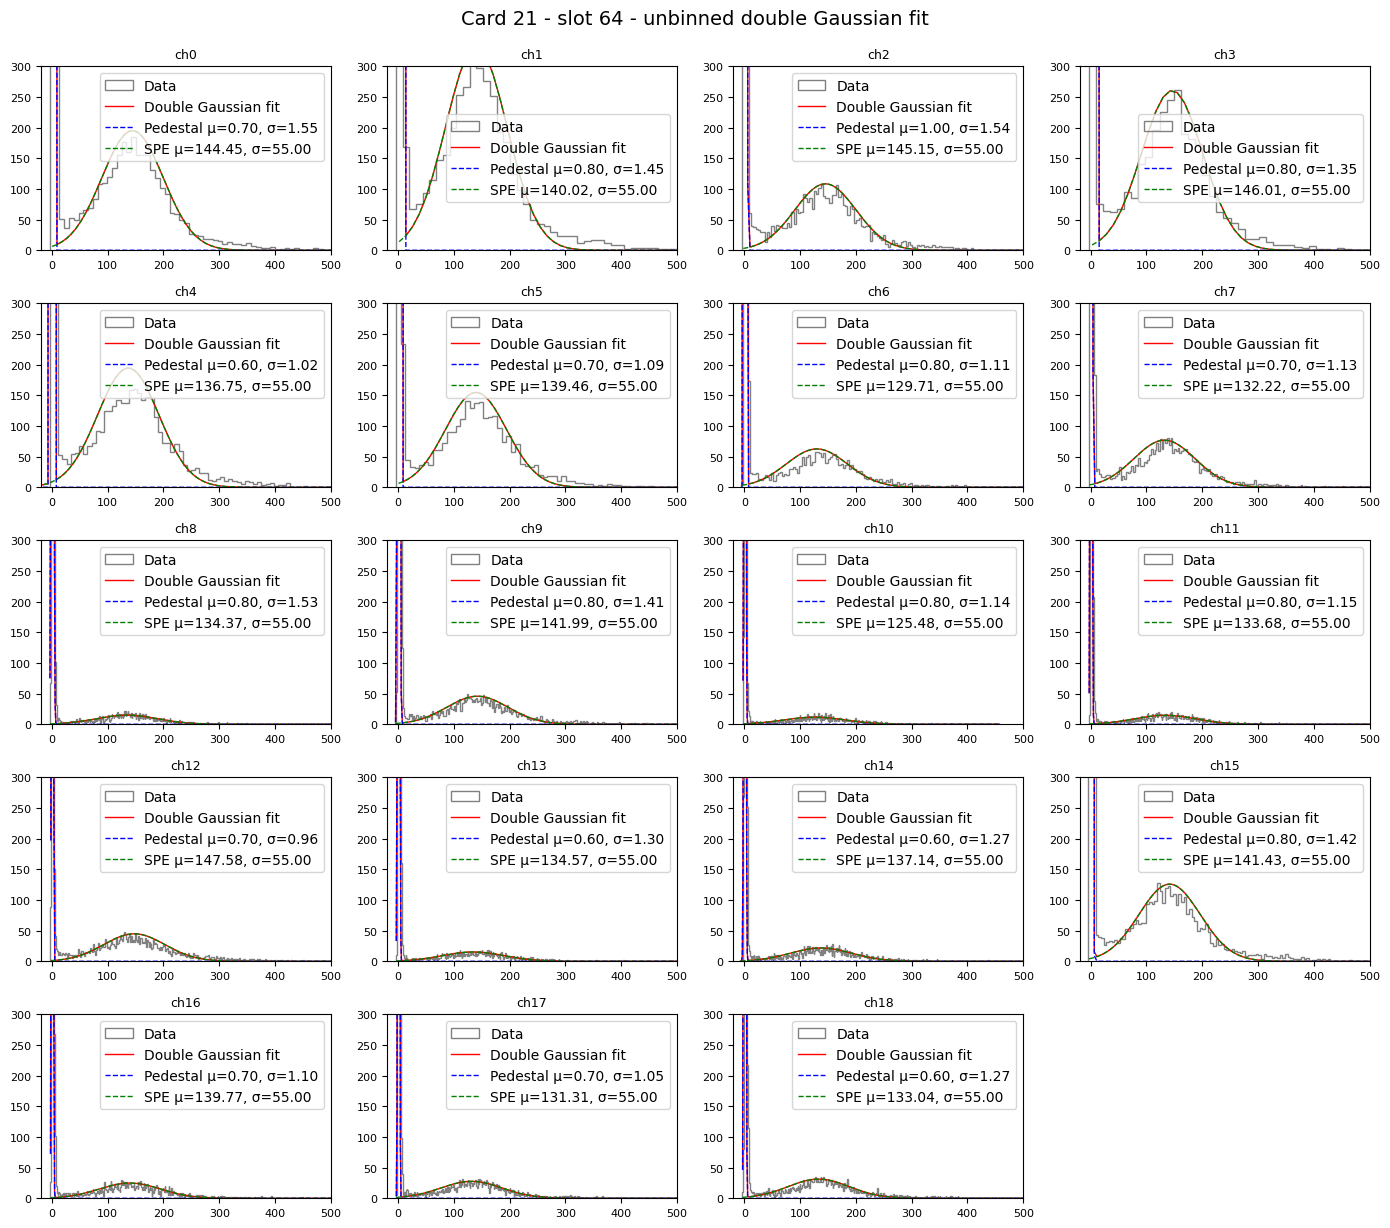

In [74]:
# --- MAIN LOOP over 19 channels ---
fig, axes = plt.subplots(5, 4, figsize=(14, 12))
axes = axes.flatten()

for channel_id in range(19):
    pmt_label = f"card{card_id}_slot{slot_id}_ch{channel_id}"
    npz_path = os.path.join(signal_dir, pmt_label + ".npz")
    if not os.path.exists(npz_path):
        print(f"Missing file: {npz_path}")
        continue

    # Load waveforms
    signal_waveforms = load_waveforms(npz_path)
    all_peaks = [do_pulse_finding(wf) for wf in signal_waveforms]

    charges = []
    for wf, peaks in zip(signal_waveforms, all_peaks):
        peak_sample = peaks[0] if len(peaks) > 0 else np.argmax(wf)
        q = charge_calculation_mPMT_method(wf, peak_sample)
        charges.append(q)
    charges = np.array(charges)

    # Fit double Gaussian
    fit = fit_double_gauss_unbinned_full(charges, n_starts=50, pmt_label=f"PMT {pmt_label}")

    # --- Plot ---
    ax = axes[channel_id]
    bins = np.linspace(charges.min(), charges.max(), 500)
    bin_centers = 0.5 * (bins[1:] + bins[:-1])
    bin_width = bins[1] - bins[0]

    pdf_ped = fit["w"] * norm.pdf(bin_centers, fit["mu1"], fit["sigma1"])
    pdf_spe = (1 - fit["w"]) * norm.pdf(bin_centers, fit["mu2"], fit["sigma2"])
    pdf_total = (pdf_ped + pdf_spe) * len(charges) * bin_width

    ax.hist(charges, bins=bins, histtype='step', color='gray', label='Data', lw=1)
    ax.plot(bin_centers, pdf_total, 'r-', lw=1, label='Double Gaussian fit')
    ax.plot(bin_centers, pdf_ped * len(charges) * bin_width, 'b--', lw=1, label=f'Pedestal μ={fit["mu1"]:.2f}, σ={fit["sigma1"]:.2f}')
    ax.plot(bin_centers, pdf_spe * len(charges) * bin_width, 'g--', lw=1, label=f'SPE μ={fit["mu2"]:.2f}, σ={fit["sigma2"]:.2f}')
    ax.set_title(f"ch{channel_id}", fontsize=9)
    ax.set_xlim(-20, 500)
    ax.set_ylim(0, 300)
    ax.legend()
    ax.tick_params(labelsize=8)

# Hide any unused subplots
for ax in axes[19:]:
    ax.axis('off')

plt.tight_layout()
plt.suptitle(f"Card {card_id} - slot {slot_id} - unbinned double Gaussian fit", fontsize=14, y=1.02)
plt.show()

#### Fitting two separate Gaussians (+ unbinned double Gaussian fit with seeds, the values found before)

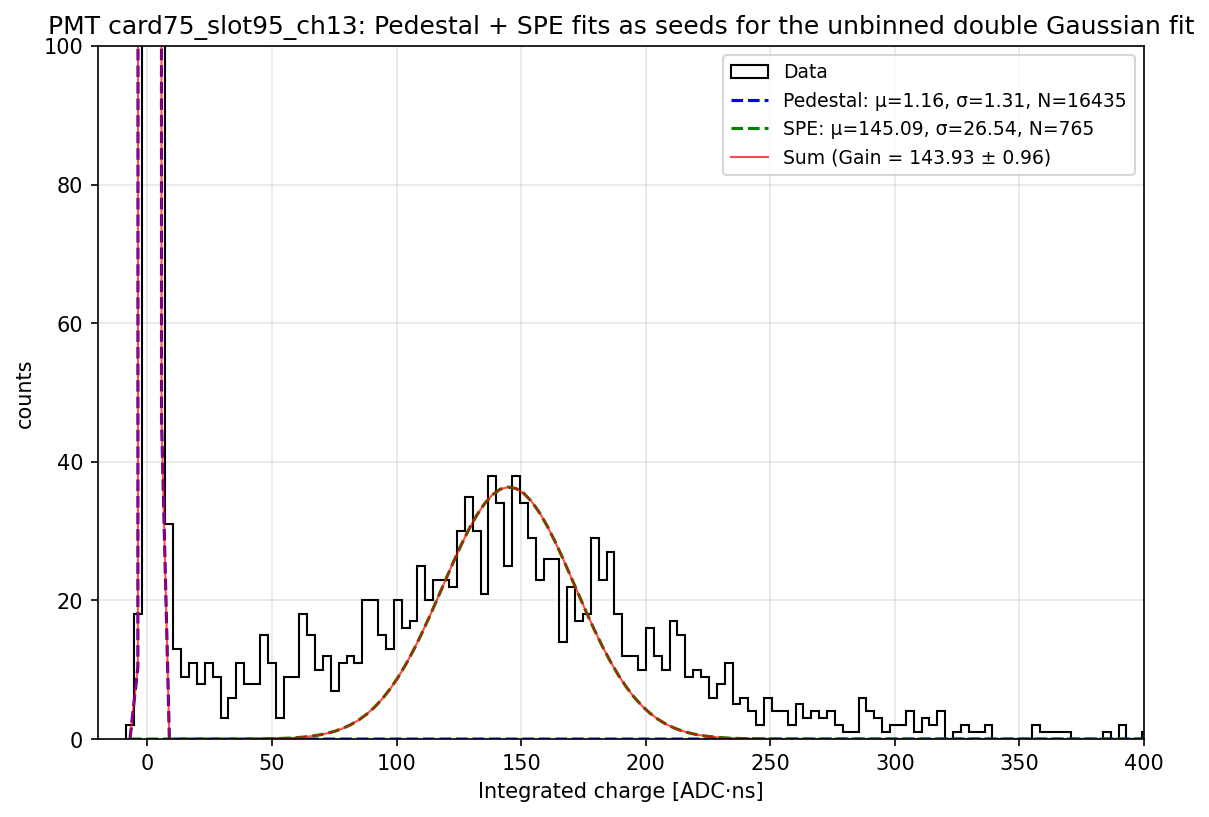


===== Pedestal Fit =====
μ₁  = 1.155  ADC·ns
σ₁  = 1.309  ADC·ns
N₁  = 16435 points

===== SPE Fit =====
μ₂  = 145.089  ADC·ns
σ₂  = 26.536  ADC·ns
N₂  = 765 points

===== Gain =====
Gain = 143.93 ± 0.96  ADC·ns


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm, gaussian_kde
from scipy.optimize import minimize
from scipy.signal import argrelextrema


# ---------------------------------------------------------
#  Unbinned Gaussian negative log-likelihood
# ---------------------------------------------------------
def nll_gauss(params, data):
    mu, sigma = params
    if sigma <= 0:
        return np.inf
    pdf = norm.pdf(data, mu, sigma)
    pdf = np.clip(pdf, 1e-12, None)
    return -np.sum(np.log(pdf))


def fit_gaussian_with_bounds(data, mu0, sigma0, sigma_bounds):
    """Fit one Gaussian with bounded sigma."""
    bounds = [
        (-np.inf, np.inf),       # μ free
        sigma_bounds             # σ bounded
    ]
    res = minimize(
        nll_gauss, 
        [mu0, sigma0],
        args=(data,),
        method="L-BFGS-B",
        bounds=bounds
    )
    if not res.success:
        raise RuntimeError("Gaussian fit failed")

    mu_fit, sigma_fit = res.x

    # uncertainties (asymptotic)
    N = len(data)
    err_mu = sigma_fit / np.sqrt(N)
    err_sigma = sigma_fit / np.sqrt(2*N)

    return dict(
        mu=mu_fit,
        sigma=sigma_fit,
        err_mu=err_mu,
        err_sigma=err_sigma,
        n=N,
        nll=res.fun
    )


# ---------------------------------------------------------
#   Main function
# ---------------------------------------------------------
def fit_pedestal_and_spe(charges, label="PMT", plot=True):

    x = np.asarray(charges)
    if len(x) < 80:
        raise RuntimeError("Too few points to identify pedestal + SPE peaks reliably")

    # -----------------------------------------------------
    #   KDE and peak finding --> to smooth the charge distribution and be able to find the two peaks
    # -----------------------------------------------------
    xs = np.linspace(np.min(x), np.max(x), 2500)
    kde = gaussian_kde(x)
    ys = kde(xs)

    peak_idx = argrelextrema(ys, np.greater)[0]
    if len(peak_idx) < 2:
        raise RuntimeError("Only one peak found — cannot separate pedestal and SPE")

    # Keep two strongest peaks
    idx_sorted = peak_idx[np.argsort(ys[peak_idx])][-2:]
    idx_sorted = np.sort(idx_sorted)

    ped_center = xs[idx_sorted[0]]
    spe_center = xs[idx_sorted[1]]

    # -----------------------------------------------------
    #    Build windows
    # -----------------------------------------------------
    # pedestal window: ±5 ADC·ns initially
    ped_mask = np.abs(x - ped_center) < 6
    # fallback widen
    if ped_mask.sum() < 20:
        ped_mask = np.abs(x - ped_center) < 10

    ped_data = x[ped_mask]

    # SPE window: automatically scale with KDE width
    sep = abs(spe_center - ped_center)
    spe_hw = max(40, 0.35 * sep)

    spe_mask = np.abs(x - spe_center) < spe_hw
    if spe_mask.sum() < 30:
        spe_mask = np.abs(x - spe_center) < (1.6 * spe_hw)

    spe_data = x[spe_mask]

    if len(spe_data) < 20:
        raise RuntimeError("Not enough points near the SPE peak for a stable fit.")

    # -----------------------------------------------------
    #     Gaussian fits with physical constraints
    # -----------------------------------------------------
    pedestal_fit = fit_gaussian_with_bounds(
        ped_data,
        mu0=np.median(ped_data),
        sigma0=np.std(ped_data) if ped_data.std()>0 else 1.0,
        sigma_bounds=(0.1, 2.0)      # <= 2 ADC·ns
    )

    spe_fit = fit_gaussian_with_bounds(
        spe_data,
        mu0=np.median(spe_data),
        sigma0=max(20, np.std(spe_data)),
        sigma_bounds=(10, 150)       # SPE sigma physically ~50–60
    )

    # gain
    gain = spe_fit["mu"] - pedestal_fit["mu"]
    err_gain = np.sqrt(pedestal_fit["err_mu"]**2 + spe_fit["err_mu"]**2)

    result = dict(
        pedestal=pedestal_fit,
        spe=spe_fit,
        gain=gain,
        err_gain=err_gain,
        n_ped=len(ped_data),
        n_spe=len(spe_data)
    )

    # -----------------------------------------------------
    #   Plot
    # -----------------------------------------------------

    if plot:
        bins = np.linspace(np.min(x), np.max(x), 500)
        bc = 0.5*(bins[1:]+bins[:-1])
        bw = bins[1] - bins[0]

        plt.figure(figsize=(9,6), dpi=150)
        plt.hist(x, bins=bins, histtype="step", color="black", lw=1, label="Data")

        ped_pdf = pedestal_fit["n"] * norm.pdf(bc, pedestal_fit["mu"], pedestal_fit["sigma"]) * bw
        spe_pdf  = spe_fit["n"] * norm.pdf(bc,  spe_fit["mu"],  spe_fit["sigma"]) * bw

        
        ped_label = (
            f"Pedestal: μ={pedestal_fit['mu']:.2f}, "
            f"σ={pedestal_fit['sigma']:.2f}, N={len(ped_data)}"
        )

        spe_label = (
            f"SPE: μ={spe_fit['mu']:.2f}, "
            f"σ={spe_fit['sigma']:.2f}, N={len(spe_data)}"
        )

        sum_label = (
            f"Sum (Gain = {gain:.2f} ± {err_gain:.2f})"
        )

        plt.plot(bc, ped_pdf, "b--", lw=1.5, label=ped_label)
        plt.plot(bc, spe_pdf,  "g--", lw=1.5, label=spe_label)
        plt.plot(bc, ped_pdf + spe_pdf, "r", lw=1, alpha=0.7, label=sum_label)

        plt.xlim(-20, 500)
        plt.ylim(0,100)
        plt.xlabel("Integrated charge [ADC·ns]")
        plt.ylabel("counts")
        plt.grid(alpha=0.3)
        plt.legend(fontsize=9)
        plt.title(f"{label}: Pedestal + SPE fits as seeds for the unbinned double Gaussian fit")

        plt.show()

    


    return result


# Example usage:
res = fit_pedestal_and_spe(charges, label=f"PMT {pmt_label}", plot=True)

print("\n===== Pedestal Fit =====")
print(f"μ₁  = {res['pedestal']['mu']:.3f}  ADC·ns")
print(f"σ₁  = {res['pedestal']['sigma']:.3f}  ADC·ns")
print(f"N₁  = {res['n_ped']} points")

print("\n===== SPE Fit =====")
print(f"μ₂  = {res['spe']['mu']:.3f}  ADC·ns")
print(f"σ₂  = {res['spe']['sigma']:.3f}  ADC·ns")
print(f"N₂  = {res['n_spe']} points")

print("\n===== Gain =====")
print(f"Gain = {res['gain']:.2f} ± {res['err_gain']:.2f}  ADC·ns")


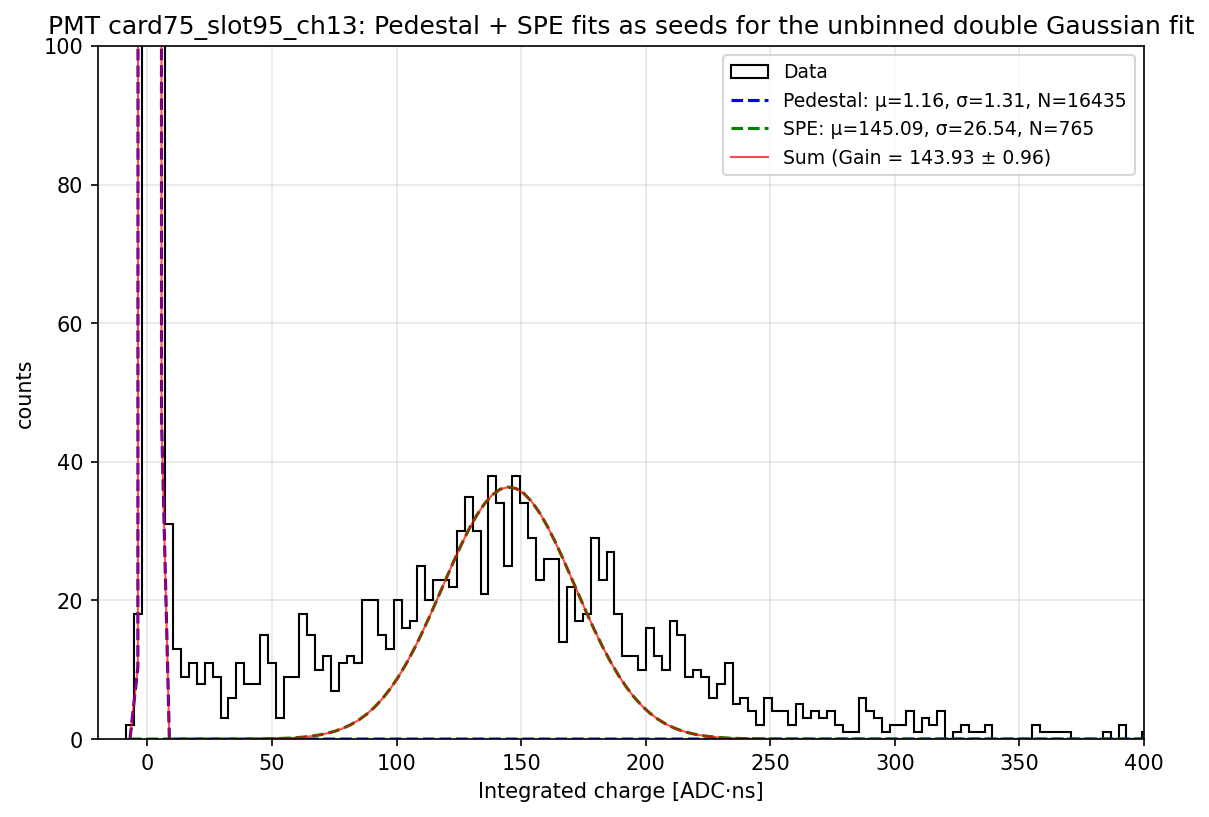

===== Region-restricted double-Gaussian fit — PMT card75_slot95_ch13 =====
Pedestal: μ₁ = 1.08, σ₁ = 1.19
SPE:      μ₂ = 147.40, σ₂ = 25.97
Weight w = 0.956
Gain = 146.31 ± 25.99 ADC·ns
Used 16918 events in restricted region.


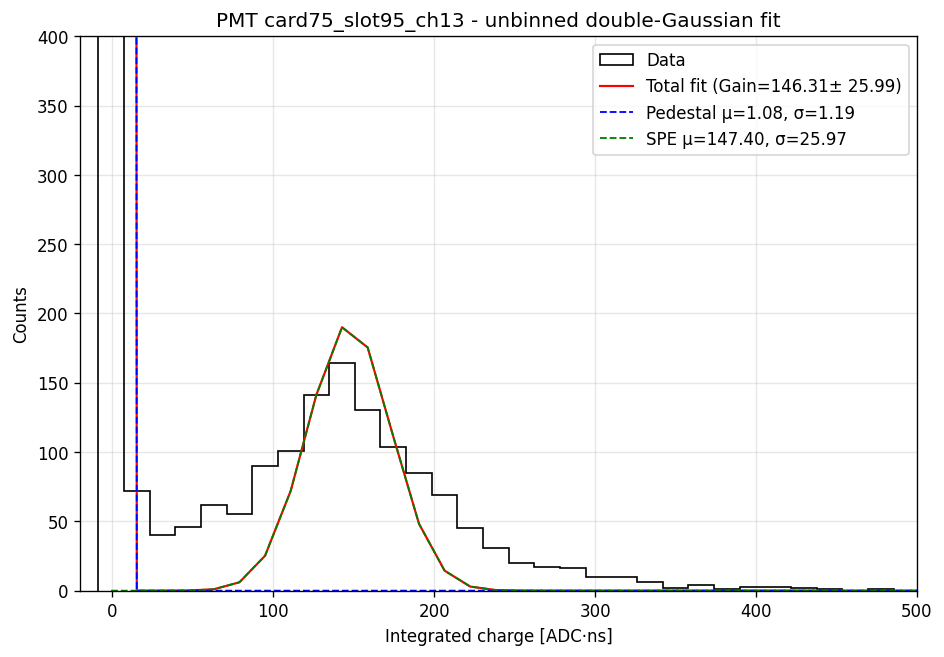

In [23]:
# =========================================================
#   UNBINNED DOUBLE-GAUSSIAN FIT USING SEPARATE PEDESTAL & SPE FITS AS SEEDS
# =========================================================


# ---------------------------------------------------------
#  Negative log-likelihood for double Gaussian
# ---------------------------------------------------------
def nll_double_gauss(params, data):
    mu1, sigma1, mu2, sigma2, w = params

    if sigma1 <= 0 or sigma2 <= 0 or not (0 < w < 1):
        return np.inf

    pdf = w * norm.pdf(data, mu1, sigma1) + (1 - w) * norm.pdf(data, mu2, sigma2)
    pdf = np.clip(pdf, 1e-12, None)

    return -np.sum(np.log(pdf))


# ---------------------------------------------------------
#  Main function
# ---------------------------------------------------------
def fit_double_gauss_unbinned_from_separate(charges, res_sep,
                                            n_starts=40,
                                            pmt_label="PMT",
                                            ped_range=(-5, 5),
                                            spe_range=(100,200)):
    """
    Unbinned double-Gaussian fit restricted to two windows:
        pedestal window: ped_range
        SPE window:      spe_range
    Uses seeds from separate pedestal/SPE fits.
    """

    # FULL DATA → but we will restrict it
    x_full = np.asarray(charges)

    # -----------------------------------------------------
    #  Restrict the likelihood region
    # -----------------------------------------------------
    ped_mask = (x_full > ped_range[0]) & (x_full < ped_range[1])
    spe_mask = (x_full > spe_range[0]) & (x_full < spe_range[1])

    x = x_full[ped_mask | spe_mask]

    if len(x) < 30:
        raise RuntimeError("Not enough data inside restricted region for unbinned fit")

    # -----------------------------------------------------
    #  Seeds from separate fits
    # -----------------------------------------------------
    mu1_seed = res_sep["pedestal"]["mu"]
    s1_seed  = res_sep["pedestal"]["sigma"]

    mu2_seed = res_sep["spe"]["mu"]
    s2_seed  = res_sep["spe"]["sigma"]

    w_seed = res_sep["n_ped"] / (res_sep["n_ped"] + res_sep["n_spe"])

    # -----------------------------------------------------
    #  Bounds
    # -----------------------------------------------------
    bounds = [
        (mu1_seed - 10, mu1_seed + 10),   # μ1 pedestal
        (0.05, 4.0),                      # σ1 pedestal
        (mu2_seed - 80, mu2_seed + 80),   # μ2 SPE
        (s2_seed - 40, s2_seed + 40),     # σ2 SPE
        (0.01, 0.99)                      # mixture weight
    ]

    # -----------------------------------------------------
    #  Build many starting points
    # -----------------------------------------------------
    rng = np.random.default_rng(1234)
    init_list = []
    init_list.append([mu1_seed, s1_seed, mu2_seed, s2_seed, w_seed])

    for _ in range(n_starts - 1):
        init_list.append([
            mu1_seed + rng.normal(scale=0.2),
            max(0.1, s1_seed + rng.normal(scale=0.1*s1_seed)),
            mu2_seed + rng.normal(scale=1.5),
            max(10, s2_seed + rng.normal(scale=0.15*s2_seed)),
            np.clip(w_seed + rng.normal(scale=0.03), 0.05, 0.95)
        ])

    # -----------------------------------------------------
    #  Minimize NLL using *restricted data x*
    # -----------------------------------------------------
    best = None
    best_nll = np.inf

    for p0 in init_list:
        try:
            res = minimize(
                nll_double_gauss,
                p0,
                args=(x,),               # <-- ONLY RESTRICTED DATA
                method="L-BFGS-B",
                bounds=bounds,
                options={'maxiter': 20000}
            )
            if res.success and res.fun < best_nll:
                best = res
                best_nll = res.fun
        except:
            pass

    if best is None:
        raise RuntimeError("Double Gaussian fit failed")

    mu1, s1, mu2, s2, w = best.x

    gain = mu2 - mu1
    err_gain = np.sqrt(s1**2 + s2**2)

    # -----------------------------------------------------
    #  Print summary
    # -----------------------------------------------------
    print(f"===== Region-restricted double-Gaussian fit — {pmt_label} =====")
    print(f"Pedestal: μ₁ = {mu1:.2f}, σ₁ = {s1:.2f}")
    print(f"SPE:      μ₂ = {mu2:.2f}, σ₂ = {s2:.2f}")
    print(f"Weight w = {w:.3f}")
    print(f"Gain = {gain:.2f} ± {err_gain:.2f} ADC·ns")
    print(f"Used {len(x)} events in restricted region.")

    return {
        "mu1": mu1, "sigma1": s1,
        "mu2": mu2, "sigma2": s2,
        "w": w,
        "gain": gain, "err_gain": err_gain,
        "nll": best_nll,
        "n_used": len(x)
    }



# ---------------------------------------------------------
#  PLOT
# ---------------------------------------------------------
def plot_double_gauss(charges, fit, label="PMT"):

    x = np.asarray(charges)
    bins = np.linspace(x.min(), x.max(), 100)
    bc = 0.5*(bins[1:] + bins[:-1])
    bw = bins[1] - bins[0]

    mu1, s1 = fit["mu1"], fit["sigma1"]
    mu2, s2 = fit["mu2"], fit["sigma2"]
    w       = fit["w"]

    pdf_ped = w * norm.pdf(bc, mu1, s1)
    pdf_spe = (1 - w) * norm.pdf(bc, mu2, s2)
    pdf_tot = (pdf_ped + pdf_spe) * len(x) * bw

    plt.figure(figsize=(9,6), dpi=120)

    plt.hist(x, bins=bins, histtype="step", color="black", lw=1, label="Data")
    plt.plot(bc, pdf_tot, 'r-', lw=1.3, label=f"Total fit (Gain={fit['gain']:.2f}± {fit['err_gain']:.2f})")
    plt.plot(bc, pdf_ped * len(x) * bw, 'b--', lw=1.1, label=f"Pedestal μ={mu1:.2f}, σ={s1:.2f}")
    plt.plot(bc, pdf_spe * len(x) * bw, 'g--', lw=1.1, label=f"SPE μ={mu2:.2f}, σ={s2:.2f}")

    #plt.text(300, 35, "σ₂=50 fixed", color='green')
    plt.xlim(-20, 500)
    plt.ylim(0,400)
    plt.xlabel("Integrated charge [ADC·ns]")
    plt.ylabel("Counts")
    plt.title(f"{label} - unbinned double-Gaussian fit")
    plt.grid(alpha=0.3)
    plt.legend()
    plt.show()


#run previous cell!!!

res_sep = fit_pedestal_and_spe(charges, label=f"PMT {pmt_label}", plot=True)


fit_dg = fit_double_gauss_unbinned_from_separate(charges, res_sep, n_starts=40, pmt_label=f"PMT {pmt_label}")
plot_double_gauss(charges, fit_dg, label=f"PMT {pmt_label}")

===== Double-Gaussian unbinned fit (using separate-fit seeds) — card21_slot64_ch0 =====
Pedestal: μ₁ = 1.10,  σ₁ = 1.49
SPE:      μ₂ = 143.87,  σ₂ = 66.34
Weight w = 0.822
Gain = 142.77 ± 66.36 ADC·ns
===== Double-Gaussian unbinned fit (using separate-fit seeds) — card21_slot64_ch1 =====
Pedestal: μ₁ = 1.11,  σ₁ = 1.40
SPE:      μ₂ = 140.09,  σ₂ = 65.56
Weight w = 0.784
Gain = 138.98 ± 65.58 ADC·ns
===== Double-Gaussian unbinned fit (using separate-fit seeds) — card21_slot64_ch2 =====
Pedestal: μ₁ = 1.31,  σ₁ = 1.50
SPE:      μ₂ = 145.29,  σ₂ = 66.12
Weight w = 0.789
Gain = 143.98 ± 66.13 ADC·ns
===== Double-Gaussian unbinned fit (using separate-fit seeds) — card21_slot64_ch3 =====
Pedestal: μ₁ = 1.17,  σ₁ = 1.29
SPE:      μ₂ = 145.46,  σ₂ = 67.37
Weight w = 0.840
Gain = 144.29 ± 67.38 ADC·ns
===== Double-Gaussian unbinned fit (using separate-fit seeds) — card21_slot64_ch4 =====
Pedestal: μ₁ = 0.80,  σ₁ = 0.98
SPE:      μ₂ = 135.69,  σ₂ = 68.20
Weight w = 0.795
Gain = 134.89 ± 68.21 AD

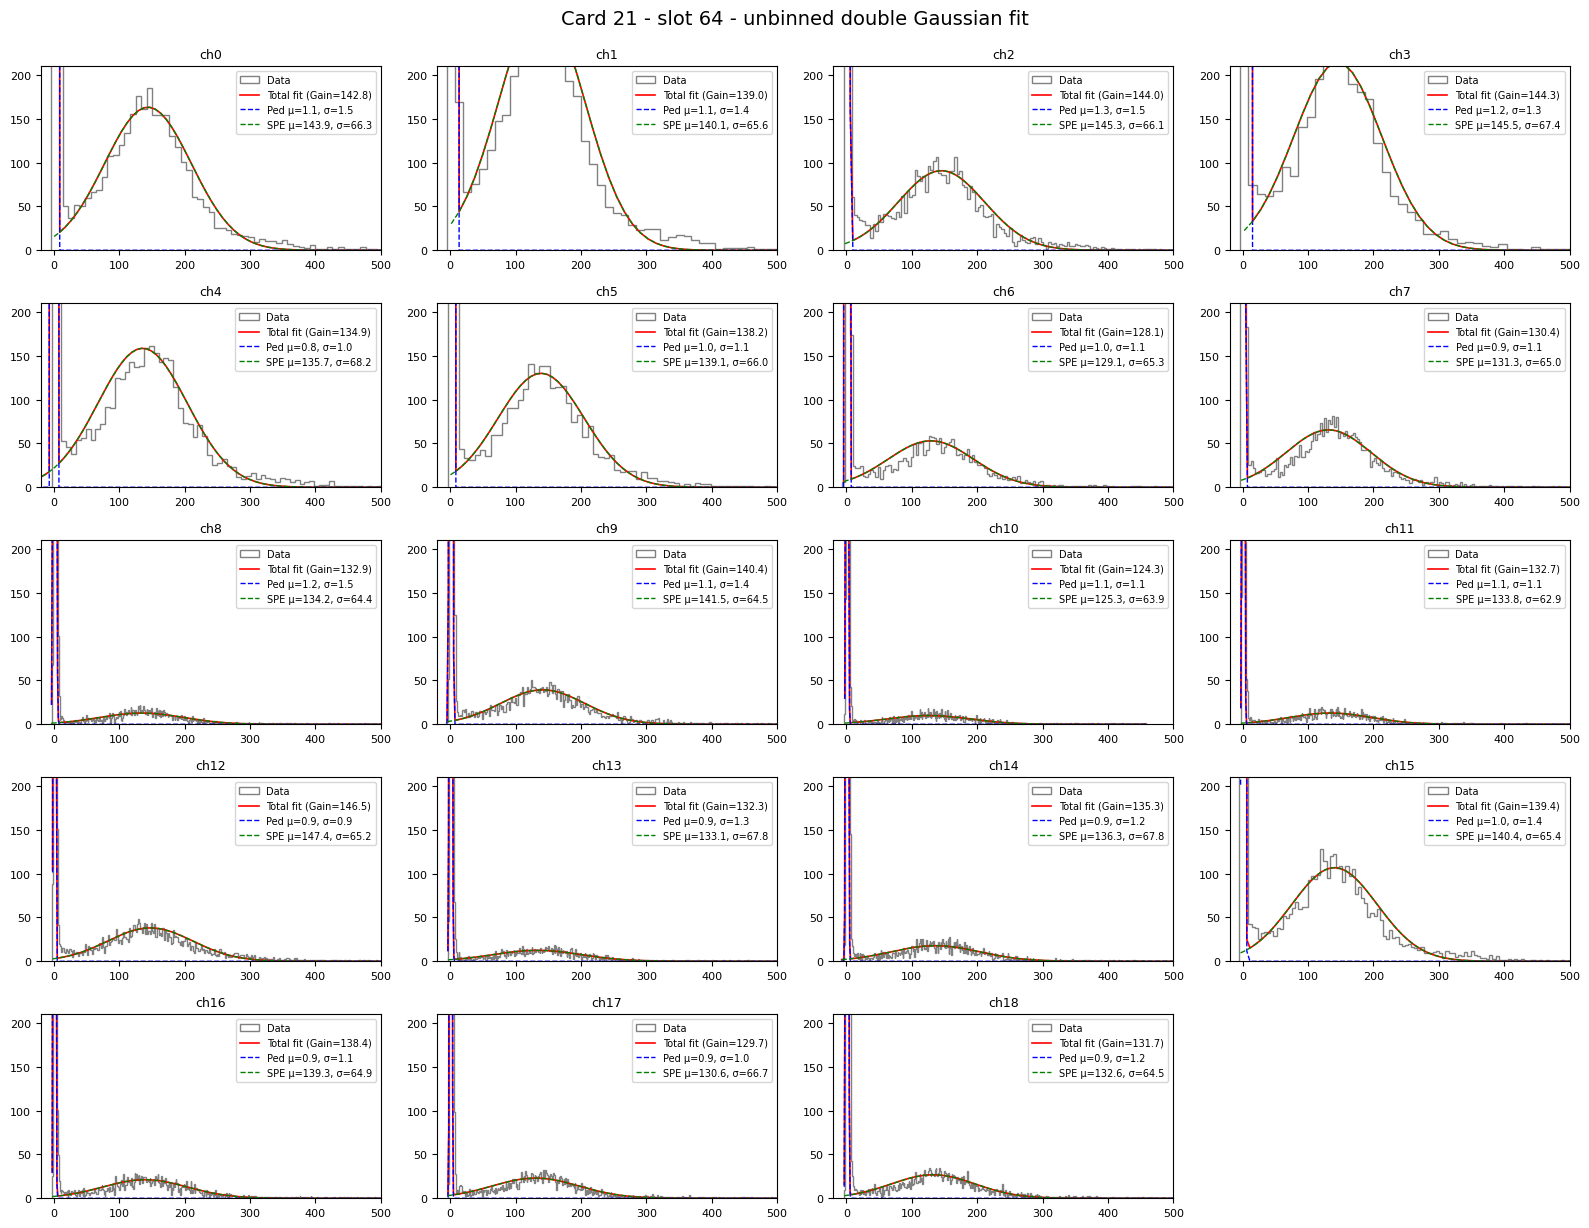

In [ ]:
import os
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm

# ---------------------------------------------------------
#  MAIN LOOP over 19 channels using seeds from separate fits
# ---------------------------------------------------------
fig, axes = plt.subplots(5, 4, figsize=(16, 12))
axes = axes.flatten()


for channel_id in range(19):
    pmt_label = f"card{card_id}_slot{slot_id}_ch{channel_id}"
    npz_path = os.path.join(signal_dir, pmt_label + ".npz")
    if not os.path.exists(npz_path):
        print(f"Missing file: {npz_path}")
        continue

    # Load waveforms
    signal_waveforms = load_waveforms(npz_path)
    all_peaks = [do_pulse_finding(wf) for wf in signal_waveforms]

    charges = []
    for wf, peaks in zip(signal_waveforms, all_peaks):
        peak_sample = peaks[0] if len(peaks) > 0 else np.argmax(wf)
        q = charge_calculation_mPMT_method(wf, peak_sample)
        charges.append(q)
    charges = np.array(charges)

    # Run separate Gaussian fits
    res_sep = fit_pedestal_and_spe(charges, label=pmt_label, plot=False)

    # Run unbinned double Gaussian fit using seeds from separate fits
    fit_dg = fit_double_gauss_unbinned_from_separate(charges, res_sep, n_starts=40, pmt_label=pmt_label)

    # --- Plot on subplot ---
    ax = axes[channel_id]
    bins = np.linspace(charges.min(), charges.max(), 500)
    bc = 0.5*(bins[1:] + bins[:-1])
    bw = bins[1] - bins[0]

    pdf_ped = fit_dg["w"] * norm.pdf(bc, fit_dg["mu1"], fit_dg["sigma1"])
    pdf_spe = (1 - fit_dg["w"]) * norm.pdf(bc, fit_dg["mu2"], fit_dg["sigma2"])
    pdf_total = (pdf_ped + pdf_spe) * len(charges) * bw

    ax.hist(charges, bins=bins, histtype='step', color='gray', lw=1, label='Data')
    ax.plot(bc, pdf_total, 'r-', lw=1.2, label=f'Total fit (Gain={fit_dg["gain"]:.1f})')
    ax.plot(bc, pdf_ped * len(charges) * bw, 'b--', lw=1, label=f'Ped μ={fit_dg["mu1"]:.1f}, σ={fit_dg["sigma1"]:.1f}')
    ax.plot(bc, pdf_spe * len(charges) * bw, 'g--', lw=1, label=f'SPE μ={fit_dg["mu2"]:.1f}, σ={fit_dg["sigma2"]:.1f}')

    ax.set_title(f"ch{channel_id}", fontsize=9)
    ax.set_xlim(-20, 500)
    ax.set_ylim(0, 210)
    ax.tick_params(labelsize=8)
    ax.legend(fontsize=7)

# Hide unused subplots
for ax in axes[19:]:
    ax.axis('off')

plt.tight_layout()
plt.suptitle(f"Card {card_id} - slot {slot_id} - unbinned double Gaussian fit", fontsize=14, y=1.02)
plt.show()

===== Double-Gaussian unbinned fit (using separate-fit seeds) — card48_slot37_ch0 =====
Pedestal: μ₁ = 0.73,  σ₁ = 0.89
SPE:      μ₂ = 144.48,  σ₂ = 67.15
Weight w = 0.827
Gain = 143.75 ± 67.16 ADC·ns
===== Double-Gaussian unbinned fit (using separate-fit seeds) — card48_slot37_ch1 =====
Pedestal: μ₁ = 1.22,  σ₁ = 1.51
SPE:      μ₂ = 151.86,  σ₂ = 65.97
Weight w = 0.749
Gain = 150.64 ± 65.99 ADC·ns
===== Double-Gaussian unbinned fit (using separate-fit seeds) — card48_slot37_ch2 =====
Pedestal: μ₁ = 1.09,  σ₁ = 1.14
SPE:      μ₂ = 148.60,  σ₂ = 66.81
Weight w = 0.720
Gain = 147.51 ± 66.82 ADC·ns
===== Double-Gaussian unbinned fit (using separate-fit seeds) — card48_slot37_ch3 =====
Pedestal: μ₁ = 1.09,  σ₁ = 1.20
SPE:      μ₂ = 141.97,  σ₂ = 66.40
Weight w = 0.813
Gain = 140.88 ± 66.41 ADC·ns
===== Double-Gaussian unbinned fit (using separate-fit seeds) — card48_slot37_ch4 =====
Pedestal: μ₁ = 0.72,  σ₁ = 1.05
SPE:      μ₂ = 146.95,  σ₂ = 68.17
Weight w = 0.731
Gain = 146.24 ± 68.18 AD

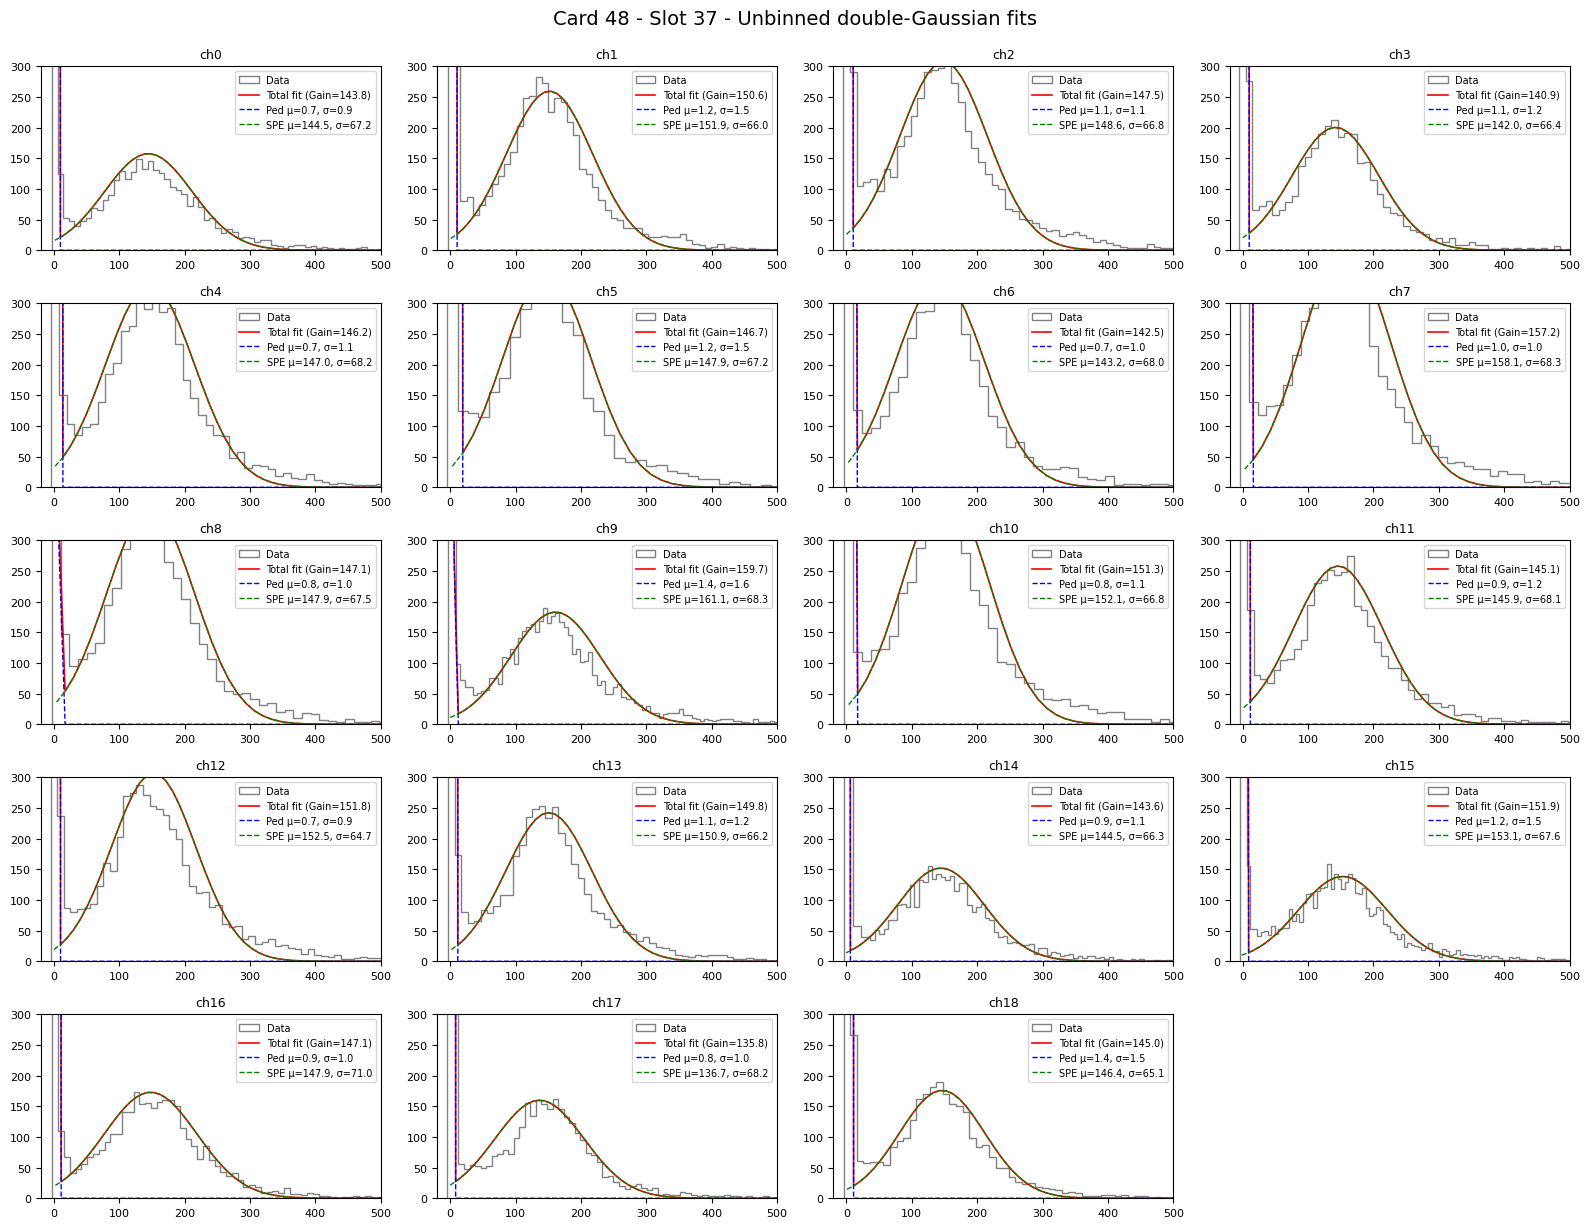

In [ ]:
#for a particular PMT

card_id = 48   
slot_id = 37 
signal_dir = "/scratch/elena/WCTE_DATA_ANALYSIS/waveform_npz/run2307"


fig, axes = plt.subplots(5, 4, figsize=(16, 12))
axes = axes.flatten()


for channel_id in range(19):
    pmt_label = f"card{card_id}_slot{slot_id}_ch{channel_id}"
    npz_path = os.path.join(signal_dir, pmt_label + ".npz")
    if not os.path.exists(npz_path):
        print(f"Missing file: {npz_path}")
        continue



    signal_waveforms = load_waveforms(npz_path)
    all_peaks = [do_pulse_finding(wf) for wf in signal_waveforms]
    charges = np.array([charge_calculation_mPMT_method(wf, (p[0] if len(p) > 0 else np.argmax(wf)))
                        for wf, p in zip(signal_waveforms, all_peaks)])


    res_sep = fit_pedestal_and_spe(charges, label=pmt_label, plot=False)


    fit_dg = fit_double_gauss_unbinned_from_separate(charges, res_sep, n_starts=40, pmt_label=pmt_label)

    # -----------------------------
    # Plot of subplots
    # -----------------------------
    ax = axes[channel_id]
    bins = np.linspace(charges.min(), charges.max(), 500)
    bc = 0.5 * (bins[1:] + bins[:-1])
    bw = bins[1] - bins[0]

    pdf_ped = fit_dg["w"] * norm.pdf(bc, fit_dg["mu1"], fit_dg["sigma1"])
    pdf_spe = (1 - fit_dg["w"]) * norm.pdf(bc, fit_dg["mu2"], fit_dg["sigma2"])
    pdf_total = (pdf_ped + pdf_spe) * len(charges) * bw

    ax.hist(charges, bins=bins, histtype='step', color='gray', lw=1, label='Data')
    ax.plot(bc, pdf_total, 'r-', lw=1.2, label=f'Total fit (Gain={fit_dg["gain"]:.1f})')
    ax.plot(bc, pdf_ped * len(charges) * bw, 'b--', lw=1, label=f'Ped μ={fit_dg["mu1"]:.1f}, σ={fit_dg["sigma1"]:.1f}')
    ax.plot(bc, pdf_spe * len(charges) * bw, 'g--', lw=1, label=f'SPE μ={fit_dg["mu2"]:.1f}, σ={fit_dg["sigma2"]:.1f}')

    ax.set_title(f"ch{channel_id}", fontsize=9)
    ax.set_xlim(-20, 500)
    ax.set_ylim(0, 300)
    ax.tick_params(labelsize=8)
    ax.legend(fontsize=7)

# Hide unused subplots
for ax in axes[19:]:
    ax.axis('off')

plt.tight_layout()
plt.suptitle(f"Card {card_id} - Slot {slot_id} - Unbinned double-Gaussian fits", fontsize=14, y=1.02)
plt.show()

## chi2

In [24]:
# -----------------------------
#  Compute chi² around SPE peak only
# -----------------------------
x = np.asarray(charges)
mu2, sigma2 = fit_dg["mu2"], fit_dg["sigma2"]
w = fit_dg["w"]

# Select data around the SPE peak: ±1.5σ or ±2σ
spe_mask = (x > mu2 - 1.5*sigma2) & (x < mu2 + 1.5*sigma2)
x_spe = x[spe_mask]

# Histogram of SPE region
bins = np.linspace(x_spe.min(), x_spe.max(), 50)
hist_counts, bin_edges = np.histogram(x_spe, bins=bins)
bin_centers = 0.5*(bin_edges[1:] + bin_edges[:-1])
bin_width = bin_edges[1] - bin_edges[0]

# Expected counts from SPE Gaussian only (not pedestal)
expected_counts = (1 - w) * norm.pdf(bin_centers, mu2, sigma2) * len(x) * bin_width

# Avoid zero counts in expected (to prevent division by zero)
expected_counts = np.clip(expected_counts, 1e-6, None)

# Chi²
chi2 = np.sum((hist_counts - expected_counts)**2 / expected_counts)
ndof = len(hist_counts) - 2  # μ2 and sigma2 fitted locally

print(f"PMT {pmt_label}: SPE chi² = {chi2:.2f}, chi²/ndof = {chi2/ndof:.2f}")

PMT card48_slot37_ch18: SPE chi² = 83.04, chi²/ndof = 1.77


In [25]:
import numpy as np
from scipy.stats import norm
import os

chi2_results = {}

for channel_id in range(19):
    pmt_label = f"card{card_id}_slot{slot_id}_ch{channel_id}"
    signal_npz = os.path.join(signal_dir, pmt_label + ".npz")
    if not os.path.exists(signal_npz):
        print(f"Missing file: {signal_npz}")
        continue

    # Load waveforms
    signal_waveforms = load_waveforms(signal_npz)
    all_peaks = [do_pulse_finding(wf) for wf in signal_waveforms]

    # Charges
    charges = []
    for wf, peaks in zip(signal_waveforms, all_peaks):
        peak_sample = peaks[0] if len(peaks) > 0 else np.argmax(wf)
        q = charge_calculation_mPMT_method(wf, peak_sample)
        charges.append(q)
    charges = np.array(charges)

    # Fit pedestal + SPE separately
    res_sep = fit_pedestal_and_spe(charges, label=pmt_label, plot=False)

    # Fit unbinned double Gaussian
    fit_dg = fit_double_gauss_unbinned_from_separate(charges, res_sep, n_starts=40, pmt_label=pmt_label)

    # -----------------------------
    # Compute SPE chi²
    # -----------------------------
    x = charges
    mu2, sigma2 = fit_dg["mu2"], fit_dg["sigma2"]
    w = fit_dg["w"]

    spe_mask = (x > mu2 - 1.5*sigma2) & (x < mu2 + 1.5*sigma2)
    x_spe = x[spe_mask]

    if len(x_spe) < 5:  # evita errores por muy pocos datos
        print(f"Ch{channel_id}: Not enough points near SPE for chi²")
        continue

    bins = np.linspace(x_spe.min(), x_spe.max(), 50)
    hist_counts, bin_edges = np.histogram(x_spe, bins=bins)
    bin_centers = 0.5*(bin_edges[1:] + bin_edges[:-1])
    bin_width = bin_edges[1] - bin_edges[0]

    expected_counts = (1 - w) * norm.pdf(bin_centers, mu2, sigma2) * len(x) * bin_width
    expected_counts = np.clip(expected_counts, 1e-6, None)

    chi2 = np.sum((hist_counts - expected_counts)**2 / expected_counts)
    ndof = len(hist_counts) - 2

    chi2_results[channel_id] = (chi2, chi2/ndof)
    print(f"Ch{channel_id}: SPE chi² = {chi2:.2f}, chi²/ndof = {chi2/ndof:.2f}")

# chi2_results ahora contiene todos los 19 canales

===== Double-Gaussian unbinned fit (using separate-fit seeds) — card48_slot37_ch0 =====
Pedestal: μ₁ = 0.73,  σ₁ = 0.89
SPE:      μ₂ = 144.48,  σ₂ = 67.15
Weight w = 0.827
Gain = 143.75 ± 67.16 ADC·ns
Ch0: SPE chi² = 96.42, chi²/ndof = 2.05
===== Double-Gaussian unbinned fit (using separate-fit seeds) — card48_slot37_ch1 =====
Pedestal: μ₁ = 1.22,  σ₁ = 1.51
SPE:      μ₂ = 151.86,  σ₂ = 65.97
Weight w = 0.749
Gain = 150.64 ± 65.99 ADC·ns
Ch1: SPE chi² = 135.93, chi²/ndof = 2.89
===== Double-Gaussian unbinned fit (using separate-fit seeds) — card48_slot37_ch2 =====
Pedestal: μ₁ = 1.09,  σ₁ = 1.14
SPE:      μ₂ = 148.60,  σ₂ = 66.81
Weight w = 0.720
Gain = 147.51 ± 66.82 ADC·ns
Ch2: SPE chi² = 161.25, chi²/ndof = 3.43
===== Double-Gaussian unbinned fit (using separate-fit seeds) — card48_slot37_ch3 =====
Pedestal: μ₁ = 1.09,  σ₁ = 1.20
SPE:      μ₂ = 141.97,  σ₂ = 66.40
Weight w = 0.813
Gain = 140.88 ± 66.41 ADC·ns
Ch3: SPE chi² = 82.32, chi²/ndof = 1.75
===== Double-Gaussian unbinned fit

In [21]:
print(chi2_results)

{0: (427.34975412602824, 9.092547960128261), 1: (454.5648029327334, 9.671591551760285), 2: (311.2459958149821, 6.622255230106003), 3: (245.20979308127383, 5.217229640027103), 4: (249.61727305743628, 5.311005809732687), 5: (147.37277924803752, 3.1355910478305855), 6: (78.55069136674508, 1.6712913056754273), 7: (183.0226005378911, 3.8940978837849167), 8: (81.04497137808183, 1.7243610931506772), 9: (163.50487452718107, 3.4788271175995975), 10: (47.59500040184858, 1.012659583018055), 11: (55.20936390218922, 1.1746673170678557), 12: (239.2336249580273, 5.090077126766539), 13: (63.91811425973361, 1.3599598778666726), 14: (65.27034553804857, 1.388730756128693), 15: (428.33766734835933, 9.113567390390624), 16: (235.87427431678495, 5.01860158120819), 17: (457.53960816355914, 9.734885280075726), 18: (348.20187142965324, 7.408550455950069)}


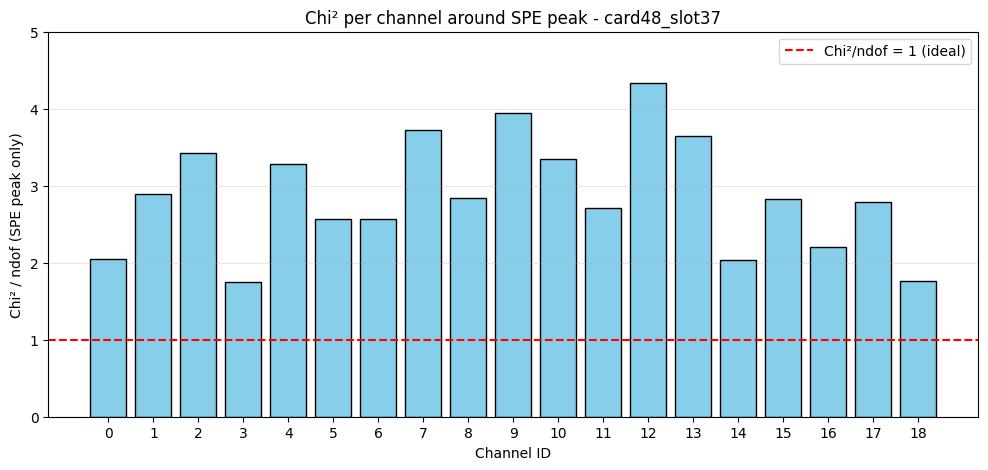

In [27]:
import matplotlib.pyplot as plt

# chi2_results ya tiene la forma {channel_id: (chi2, chi2/ndof)}
channels = sorted(chi2_results.keys())
chi2_ndof = [chi2_results[ch][1] for ch in channels]

plt.figure(figsize=(12,5))
plt.bar(channels, chi2_ndof, color='skyblue', edgecolor='k')
plt.axhline(1, color='r', linestyle='--', label='Chi²/ndof = 1 (ideal)')
plt.xlabel("Channel ID")
plt.ylabel("Chi² / ndof (SPE peak only)")
plt.title(f"Chi² per channel around SPE peak - card{card_id}_slot{slot_id}")
plt.xticks(channels)
plt.ylim(0,5)
#plt.ylim(0, max(chi2_ndof)*1.2)
plt.grid(alpha=0.3, axis='y')
plt.legend()
plt.show()

# Fit summary: seeds, bounds, and extraction windows

---

## 1️⃣ Fit individual de pedestal (Gaussian unbinned)

- **Datos usados:** `ped_data` → puntos dentro de la ventana alrededor del pico del pedestal.
- **Seed (inicial):**  
  - `mu0 = np.median(ped_data)` → centro aproximado del pico del pedestal.  
  - `sigma0 = np.std(ped_data)` si >0, sino 1.0.
- **Bounds:**  
  - `μ` (media) → libre: `(-∞, ∞)`  
  - `σ` (sigma) → `(0.1, 2.0)` ADC·ns (físicamente el pedestal es muy estrecho)  

---

## 2️⃣ Fit individual de SPE (Gaussian unbinned)

- **Datos usados:** `spe_data` → puntos dentro de la ventana alrededor del pico SPE.  
  - **Ventana:**  
    - `spe_hw = max(40, 0.35 * |spe_center - ped_center|)`  
    - Se toman todos los puntos `|x - spe_center| < spe_hw`  
    - Si hay pocos (<30), se amplía a `1.6 * spe_hw`  
- **Seed (inicial):**  
  - `mu0 = np.median(spe_data)`  
  - `sigma0 = max(20, np.std(spe_data))`  
- **Bounds:**  
  - `σ` (sigma) → `(10.0, 150.0)` ADC·ns (físicamente el SPE es más ancho que el pedestal)  

---

## 3️⃣ Fit double-Gaussian unbinned (usando seeds de pedestal + SPE)

- **Parámetros:** `[mu1, sigma1, mu2, sigma2, w]`  
  - `mu1`, `sigma1` → pedestal  
  - `mu2`, `sigma2` → SPE  
  - `w` → fracción de pedestal (mezcla: `0 < w < 1`)  

- **Seeds iniciales:**
  - `mu1_seed = res_sep['pedestal']['mu']`  
  - `s1_seed = res_sep['pedestal']['sigma']`  
  - `mu2_seed = res_sep['spe']['mu']`  
  - `s2_seed = res_sep['spe']['sigma']`  
  - `w_seed = n_ped / (n_ped + n_spe)`  

- **Bounds:**
  - `mu1`: `(mu1_seed - 10, mu1_seed + 10)`  
  - `sigma1`: `(0.05, 4)`  
  - `mu2`: `(mu2_seed - 80, mu2_seed + 80)`  
  - `sigma2`: `(s2_seed - 40, s2_seed + 40)`  
  - `w`: `(0.01, 0.99)`  

- **Múltiples inicios:**  
  - Se generan 40 combinaciones iniciales alrededor de estos seeds, con ligeras perturbaciones gaussianas:  
    - `mu1_seed + normal(scale=0.2)`  
    - `s1_seed + normal(scale=0.1*s1_seed)`  
    - `mu2_seed + normal(scale=1.5)`  
    - `s2_seed + normal(scale=0.15*s2_seed)`  
    - `w_seed + normal(scale=0.03)` (clip a `[0.05, 0.95]`)  

- **Nota:**  
  - El objetivo es que el optimizador **no quede atrapado en mínimos locales**, usando distintos puntos de partida.
